In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()


In [4]:
data_df.shape

(11039, 45)

In [5]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [7]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-07 01:23:55.284092: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [9]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [10]:
print(N_y)

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
fluorescein10^-5bin2      14067051
fluorescein10^-5bin3      14797633
fluorescein10^-6.5bin0     7778006
fluorescein10^-6.5bin1     1084990
fluorescein10^-6.5bin2     6335215
fluorescein10^-6.5bin3    14460000
fluorescein10^-6bin0       1870048
fluorescein10^-6bin1       6027256
fluorescein10^-6bin2       2933272
fluorescein10^-6bin3      10097157
fluorescein10^-7.5bin0     3535644
fluorescein10^-7.5bin1     1078611
fluorescein10^-7.5bin2     3070755
fluorescein10^-7.5bin3     3000078
fluorescein10^-7bin0       3645702
fluorescein10^-7bin1        565856
fluorescein10^-7bin2       8837515
fluorescein10^-7bin3       2756860
fluorescein10^-8.5bi

#### I approximated these values from Fig 2B

In [11]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [12]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [13]:
mp_list = [mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=10,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [14]:
# there are 16 measurement processes in this 
len(mp_list)

11

In [15]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

In [16]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 444)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 400)          0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           401         ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [17]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 19.9% for validation.
Time to set data: 0.437 sec.


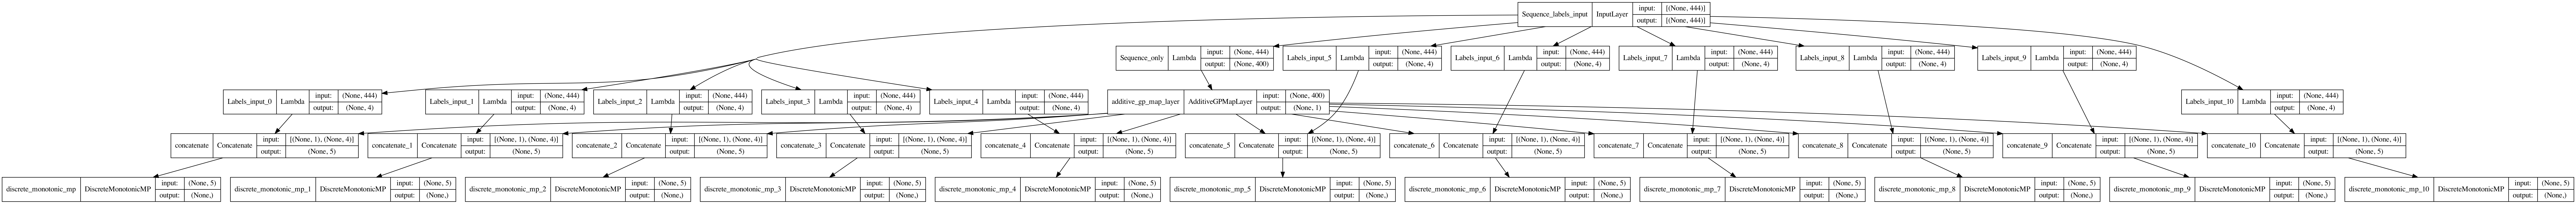

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='pngs/DiscreteMonotonic_MP/titeseq16_dar.png')

In [19]:

# Fit model to data
model.fit(learning_rate=.0001,
          epochs=750,
          batch_size=250,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=50,
          linear_initialization=False)

Epoch 1/750
34/34 [==============================] - 8s 46ms/step - loss: 10848835.0000 - discrete_monotonic_mp_loss: 1521802.1250 - discrete_monotonic_mp_1_loss: 735382.3750 - discrete_monotonic_mp_2_loss: 1501238.5000 - discrete_monotonic_mp_3_loss: 955902.9375 - discrete_monotonic_mp_4_loss: 632624.6250 - discrete_monotonic_mp_5_loss: 396930.4688 - discrete_monotonic_mp_6_loss: 578018.5625 - discrete_monotonic_mp_7_loss: 1614933.7500 - discrete_monotonic_mp_8_loss: 776551.1875 - discrete_monotonic_mp_9_loss: 1133867.5000 - discrete_monotonic_mp_10_loss: 1001580.6875 - I_var: -0.2452 - val_loss: 7236680.0000 - val_discrete_monotonic_mp_loss: 878330.7500 - val_discrete_monotonic_mp_1_loss: 604515.6875 - val_discrete_monotonic_mp_2_loss: 1097546.5000 - val_discrete_monotonic_mp_3_loss: 636940.6875 - val_discrete_monotonic_mp_4_loss: 478567.0625 - val_discrete_monotonic_mp_5_loss: 311192.8125 - val_discrete_monotonic_mp_6_loss: 393543.6250 - val_discrete_monotonic_mp_7_loss: 945785.2500

34/34 [==============================] - 0s 7ms/step - loss: 10191019.0000 - discrete_monotonic_mp_loss: 1307149.1250 - discrete_monotonic_mp_1_loss: 730835.9375 - discrete_monotonic_mp_2_loss: 1409190.5000 - discrete_monotonic_mp_3_loss: 923194.0000 - discrete_monotonic_mp_4_loss: 617630.5625 - discrete_monotonic_mp_5_loss: 366432.1250 - discrete_monotonic_mp_6_loss: 537860.4375 - discrete_monotonic_mp_7_loss: 1424499.1250 - discrete_monotonic_mp_8_loss: 746327.5000 - discrete_monotonic_mp_9_loss: 1131717.2500 - discrete_monotonic_mp_10_loss: 996182.5000 - I_var: -0.1674 - val_loss: 6670067.0000 - val_discrete_monotonic_mp_loss: 768980.1250 - val_discrete_monotonic_mp_1_loss: 585324.5625 - val_discrete_monotonic_mp_2_loss: 1003786.6250 - val_discrete_monotonic_mp_3_loss: 592596.3750 - val_discrete_monotonic_mp_4_loss: 448831.3125 - val_discrete_monotonic_mp_5_loss: 281449.4688 - val_discrete_monotonic_mp_6_loss: 365248.8125 - val_discrete_monotonic_mp_7_loss: 809782.9375 - val_discret

34/34 [==============================] - 0s 6ms/step - loss: 9986468.0000 - discrete_monotonic_mp_loss: 1218021.1250 - discrete_monotonic_mp_1_loss: 731552.6250 - discrete_monotonic_mp_2_loss: 1390137.7500 - discrete_monotonic_mp_3_loss: 918778.6875 - discrete_monotonic_mp_4_loss: 620633.6250 - discrete_monotonic_mp_5_loss: 358878.7188 - discrete_monotonic_mp_6_loss: 523135.3125 - discrete_monotonic_mp_7_loss: 1359021.6250 - discrete_monotonic_mp_8_loss: 739501.0000 - discrete_monotonic_mp_9_loss: 1129669.1250 - discrete_monotonic_mp_10_loss: 997137.2500 - I_var: -0.1403 - val_loss: 6475678.0000 - val_discrete_monotonic_mp_loss: 727408.7500 - val_discrete_monotonic_mp_1_loss: 576744.0000 - val_discrete_monotonic_mp_2_loss: 973749.6250 - val_discrete_monotonic_mp_3_loss: 579974.1875 - val_discrete_monotonic_mp_4_loss: 442226.1875 - val_discrete_monotonic_mp_5_loss: 272876.7812 - val_discrete_monotonic_mp_6_loss: 354797.4688 - val_discrete_monotonic_mp_7_loss: 759636.5000 - val_discrete_

34/34 [==============================] - 0s 6ms/step - loss: 9875115.0000 - discrete_monotonic_mp_loss: 1184583.7500 - discrete_monotonic_mp_1_loss: 729574.5000 - discrete_monotonic_mp_2_loss: 1381783.2500 - discrete_monotonic_mp_3_loss: 909801.1875 - discrete_monotonic_mp_4_loss: 616409.1250 - discrete_monotonic_mp_5_loss: 356160.1250 - discrete_monotonic_mp_6_loss: 515205.7500 - discrete_monotonic_mp_7_loss: 1333975.8750 - discrete_monotonic_mp_8_loss: 735157.0625 - discrete_monotonic_mp_9_loss: 1119428.1250 - discrete_monotonic_mp_10_loss: 993035.8125 - I_var: -0.1368 - val_loss: 6390494.5000 - val_discrete_monotonic_mp_loss: 709619.1875 - val_discrete_monotonic_mp_1_loss: 570557.3125 - val_discrete_monotonic_mp_2_loss: 960785.1250 - val_discrete_monotonic_mp_3_loss: 576082.0000 - val_discrete_monotonic_mp_4_loss: 439964.9062 - val_discrete_monotonic_mp_5_loss: 270144.7188 - val_discrete_monotonic_mp_6_loss: 349271.2812 - val_discrete_monotonic_mp_7_loss: 738717.8125 - val_discrete_

34/34 [==============================] - 0s 6ms/step - loss: 9764117.0000 - discrete_monotonic_mp_loss: 1161330.0000 - discrete_monotonic_mp_1_loss: 725856.6250 - discrete_monotonic_mp_2_loss: 1371179.1250 - discrete_monotonic_mp_3_loss: 898638.1250 - discrete_monotonic_mp_4_loss: 609344.4375 - discrete_monotonic_mp_5_loss: 354001.1875 - discrete_monotonic_mp_6_loss: 507355.0312 - discrete_monotonic_mp_7_loss: 1313525.1250 - discrete_monotonic_mp_8_loss: 729088.5625 - discrete_monotonic_mp_9_loss: 1106734.3750 - discrete_monotonic_mp_10_loss: 987064.3750 - I_var: -0.1291 - val_loss: 6328373.5000 - val_discrete_monotonic_mp_loss: 697419.5625 - val_discrete_monotonic_mp_1_loss: 565001.9375 - val_discrete_monotonic_mp_2_loss: 951628.1875 - val_discrete_monotonic_mp_3_loss: 573314.3750 - val_discrete_monotonic_mp_4_loss: 438182.7188 - val_discrete_monotonic_mp_5_loss: 268376.7500 - val_discrete_monotonic_mp_6_loss: 344661.3438 - val_discrete_monotonic_mp_7_loss: 724401.0625 - val_discrete_

34/34 [==============================] - 0s 7ms/step - loss: 9680165.0000 - discrete_monotonic_mp_loss: 1144566.2500 - discrete_monotonic_mp_1_loss: 723616.6250 - discrete_monotonic_mp_2_loss: 1363683.1250 - discrete_monotonic_mp_3_loss: 888011.0625 - discrete_monotonic_mp_4_loss: 603438.1875 - discrete_monotonic_mp_5_loss: 352722.0938 - discrete_monotonic_mp_6_loss: 501104.1562 - discrete_monotonic_mp_7_loss: 1299512.6250 - discrete_monotonic_mp_8_loss: 725331.2500 - discrete_monotonic_mp_9_loss: 1095849.8750 - discrete_monotonic_mp_10_loss: 982329.0625 - I_var: -0.1272 - val_loss: 6280239.0000 - val_discrete_monotonic_mp_loss: 687875.9375 - val_discrete_monotonic_mp_1_loss: 560864.0625 - val_discrete_monotonic_mp_2_loss: 944622.5000 - val_discrete_monotonic_mp_3_loss: 571230.8750 - val_discrete_monotonic_mp_4_loss: 436955.0312 - val_discrete_monotonic_mp_5_loss: 267147.1250 - val_discrete_monotonic_mp_6_loss: 340674.3438 - val_discrete_monotonic_mp_7_loss: 713523.5000 - val_discrete_

34/34 [==============================] - 0s 6ms/step - loss: 9597149.0000 - discrete_monotonic_mp_loss: 1131816.2500 - discrete_monotonic_mp_1_loss: 721079.6250 - discrete_monotonic_mp_2_loss: 1356149.5000 - discrete_monotonic_mp_3_loss: 878564.6250 - discrete_monotonic_mp_4_loss: 597751.0625 - discrete_monotonic_mp_5_loss: 351176.7812 - discrete_monotonic_mp_6_loss: 494467.5625 - discrete_monotonic_mp_7_loss: 1285007.0000 - discrete_monotonic_mp_8_loss: 720512.1250 - discrete_monotonic_mp_9_loss: 1084319.6250 - discrete_monotonic_mp_10_loss: 976303.9375 - I_var: -0.1280 - val_loss: 6234847.5000 - val_discrete_monotonic_mp_loss: 680613.3125 - val_discrete_monotonic_mp_1_loss: 556911.2500 - val_discrete_monotonic_mp_2_loss: 937772.1875 - val_discrete_monotonic_mp_3_loss: 569011.6875 - val_discrete_monotonic_mp_4_loss: 435623.5312 - val_discrete_monotonic_mp_5_loss: 265937.2500 - val_discrete_monotonic_mp_6_loss: 336963.6562 - val_discrete_monotonic_mp_7_loss: 702854.2500 - val_discrete_

34/34 [==============================] - 0s 7ms/step - loss: 9518002.0000 - discrete_monotonic_mp_loss: 1119205.3750 - discrete_monotonic_mp_1_loss: 718024.6875 - discrete_monotonic_mp_2_loss: 1348841.6250 - discrete_monotonic_mp_3_loss: 869062.0000 - discrete_monotonic_mp_4_loss: 592552.9375 - discrete_monotonic_mp_5_loss: 349894.3438 - discrete_monotonic_mp_6_loss: 488488.3750 - discrete_monotonic_mp_7_loss: 1269315.2500 - discrete_monotonic_mp_8_loss: 716065.1250 - discrete_monotonic_mp_9_loss: 1074566.6250 - discrete_monotonic_mp_10_loss: 971985.1875 - I_var: -0.1176 - val_loss: 6198562.5000 - val_discrete_monotonic_mp_loss: 674292.3125 - val_discrete_monotonic_mp_1_loss: 554046.4375 - val_discrete_monotonic_mp_2_loss: 932614.0625 - val_discrete_monotonic_mp_3_loss: 567048.6250 - val_discrete_monotonic_mp_4_loss: 434665.8750 - val_discrete_monotonic_mp_5_loss: 265280.9375 - val_discrete_monotonic_mp_6_loss: 333618.4375 - val_discrete_monotonic_mp_7_loss: 694493.0000 - val_discrete_

34/34 [==============================] - 0s 6ms/step - loss: 9444615.0000 - discrete_monotonic_mp_loss: 1108809.7500 - discrete_monotonic_mp_1_loss: 716365.9375 - discrete_monotonic_mp_2_loss: 1341598.2500 - discrete_monotonic_mp_3_loss: 861013.4375 - discrete_monotonic_mp_4_loss: 587312.8125 - discrete_monotonic_mp_5_loss: 348726.9062 - discrete_monotonic_mp_6_loss: 482997.0625 - discrete_monotonic_mp_7_loss: 1256774.5000 - discrete_monotonic_mp_8_loss: 711334.1250 - discrete_monotonic_mp_9_loss: 1063566.2500 - discrete_monotonic_mp_10_loss: 966114.8750 - I_var: -0.1221 - val_loss: 6159637.0000 - val_discrete_monotonic_mp_loss: 668308.8125 - val_discrete_monotonic_mp_1_loss: 551020.5000 - val_discrete_monotonic_mp_2_loss: 927053.1875 - val_discrete_monotonic_mp_3_loss: 564464.8125 - val_discrete_monotonic_mp_4_loss: 433341.8438 - val_discrete_monotonic_mp_5_loss: 264541.6250 - val_discrete_monotonic_mp_6_loss: 330513.4062 - val_discrete_monotonic_mp_7_loss: 685787.0000 - val_discrete_

34/34 [==============================] - 0s 6ms/step - loss: 9374170.0000 - discrete_monotonic_mp_loss: 1097068.7500 - discrete_monotonic_mp_1_loss: 713725.4375 - discrete_monotonic_mp_2_loss: 1333713.8750 - discrete_monotonic_mp_3_loss: 853098.2500 - discrete_monotonic_mp_4_loss: 582888.5000 - discrete_monotonic_mp_5_loss: 347229.8750 - discrete_monotonic_mp_6_loss: 477576.3750 - discrete_monotonic_mp_7_loss: 1244275.8750 - discrete_monotonic_mp_8_loss: 706636.2500 - discrete_monotonic_mp_9_loss: 1057147.8750 - discrete_monotonic_mp_10_loss: 960809.7500 - I_var: -0.1147 - val_loss: 6120175.0000 - val_discrete_monotonic_mp_loss: 662574.6250 - val_discrete_monotonic_mp_1_loss: 548240.4375 - val_discrete_monotonic_mp_2_loss: 921661.9375 - val_discrete_monotonic_mp_3_loss: 561260.9375 - val_discrete_monotonic_mp_4_loss: 431661.1250 - val_discrete_monotonic_mp_5_loss: 263749.5000 - val_discrete_monotonic_mp_6_loss: 327598.3750 - val_discrete_monotonic_mp_7_loss: 677441.1250 - val_discrete_

34/34 [==============================] - 0s 7ms/step - loss: 9320876.0000 - discrete_monotonic_mp_loss: 1088199.5000 - discrete_monotonic_mp_1_loss: 712291.3750 - discrete_monotonic_mp_2_loss: 1328397.0000 - discrete_monotonic_mp_3_loss: 845698.9375 - discrete_monotonic_mp_4_loss: 579192.3750 - discrete_monotonic_mp_5_loss: 346795.2188 - discrete_monotonic_mp_6_loss: 473398.8750 - discrete_monotonic_mp_7_loss: 1234280.1250 - discrete_monotonic_mp_8_loss: 703383.2500 - discrete_monotonic_mp_9_loss: 1050986.7500 - discrete_monotonic_mp_10_loss: 958252.3750 - I_var: -0.1094 - val_loss: 6088045.0000 - val_discrete_monotonic_mp_loss: 657557.0625 - val_discrete_monotonic_mp_1_loss: 545895.6250 - val_discrete_monotonic_mp_2_loss: 917434.2500 - val_discrete_monotonic_mp_3_loss: 558748.1875 - val_discrete_monotonic_mp_4_loss: 430361.0312 - val_discrete_monotonic_mp_5_loss: 263211.9062 - val_discrete_monotonic_mp_6_loss: 324978.5312 - val_discrete_monotonic_mp_7_loss: 670782.4375 - val_discrete_

34/34 [==============================] - 0s 8ms/step - loss: 9251569.0000 - discrete_monotonic_mp_loss: 1078952.8750 - discrete_monotonic_mp_1_loss: 709642.0625 - discrete_monotonic_mp_2_loss: 1321808.3750 - discrete_monotonic_mp_3_loss: 838463.5000 - discrete_monotonic_mp_4_loss: 574640.4375 - discrete_monotonic_mp_5_loss: 345130.1250 - discrete_monotonic_mp_6_loss: 468448.1250 - discrete_monotonic_mp_7_loss: 1221114.6250 - discrete_monotonic_mp_8_loss: 698848.3125 - discrete_monotonic_mp_9_loss: 1042088.8750 - discrete_monotonic_mp_10_loss: 952431.3125 - I_var: -0.1130 - val_loss: 6054254.0000 - val_discrete_monotonic_mp_loss: 653058.6875 - val_discrete_monotonic_mp_1_loss: 543648.2500 - val_discrete_monotonic_mp_2_loss: 912967.7500 - val_discrete_monotonic_mp_3_loss: 555707.4375 - val_discrete_monotonic_mp_4_loss: 428690.1250 - val_discrete_monotonic_mp_5_loss: 262624.5938 - val_discrete_monotonic_mp_6_loss: 322714.8750 - val_discrete_monotonic_mp_7_loss: 663833.0625 - val_discrete_

34/34 [==============================] - 0s 7ms/step - loss: 9201053.0000 - discrete_monotonic_mp_loss: 1071019.2500 - discrete_monotonic_mp_1_loss: 708226.2500 - discrete_monotonic_mp_2_loss: 1316706.8750 - discrete_monotonic_mp_3_loss: 831545.4375 - discrete_monotonic_mp_4_loss: 571591.0000 - discrete_monotonic_mp_5_loss: 344341.3750 - discrete_monotonic_mp_6_loss: 464872.0000 - discrete_monotonic_mp_7_loss: 1212677.1250 - discrete_monotonic_mp_8_loss: 695203.8750 - discrete_monotonic_mp_9_loss: 1036709.9375 - discrete_monotonic_mp_10_loss: 948159.9375 - I_var: -0.0983 - val_loss: 6018106.0000 - val_discrete_monotonic_mp_loss: 648883.4375 - val_discrete_monotonic_mp_1_loss: 541364.5625 - val_discrete_monotonic_mp_2_loss: 908305.7500 - val_discrete_monotonic_mp_3_loss: 552020.4375 - val_discrete_monotonic_mp_4_loss: 426571.7812 - val_discrete_monotonic_mp_5_loss: 261903.9375 - val_discrete_monotonic_mp_6_loss: 320662.5312 - val_discrete_monotonic_mp_7_loss: 656614.9375 - val_discrete_

34/34 [==============================] - 0s 6ms/step - loss: 9145789.0000 - discrete_monotonic_mp_loss: 1064078.7500 - discrete_monotonic_mp_1_loss: 706472.4375 - discrete_monotonic_mp_2_loss: 1310831.8750 - discrete_monotonic_mp_3_loss: 824847.1875 - discrete_monotonic_mp_4_loss: 567863.8125 - discrete_monotonic_mp_5_loss: 343229.1875 - discrete_monotonic_mp_6_loss: 461078.7188 - discrete_monotonic_mp_7_loss: 1202557.7500 - discrete_monotonic_mp_8_loss: 691016.2500 - discrete_monotonic_mp_9_loss: 1030287.8125 - discrete_monotonic_mp_10_loss: 943525.8750 - I_var: -0.0819 - val_loss: 5989192.5000 - val_discrete_monotonic_mp_loss: 645179.5000 - val_discrete_monotonic_mp_1_loss: 539617.5625 - val_discrete_monotonic_mp_2_loss: 904697.5625 - val_discrete_monotonic_mp_3_loss: 549218.8750 - val_discrete_monotonic_mp_4_loss: 425102.6875 - val_discrete_monotonic_mp_5_loss: 261547.0469 - val_discrete_monotonic_mp_6_loss: 318555.0625 - val_discrete_monotonic_mp_7_loss: 650862.0000 - val_discrete_

34/34 [==============================] - 0s 7ms/step - loss: 9098353.0000 - discrete_monotonic_mp_loss: 1057112.5000 - discrete_monotonic_mp_1_loss: 704570.8750 - discrete_monotonic_mp_2_loss: 1306532.2500 - discrete_monotonic_mp_3_loss: 819205.1250 - discrete_monotonic_mp_4_loss: 564671.8750 - discrete_monotonic_mp_5_loss: 342231.0000 - discrete_monotonic_mp_6_loss: 458195.0312 - discrete_monotonic_mp_7_loss: 1193739.3750 - discrete_monotonic_mp_8_loss: 687681.3125 - discrete_monotonic_mp_9_loss: 1025171.6875 - discrete_monotonic_mp_10_loss: 939240.6875 - I_var: -0.0734 - val_loss: 5953728.0000 - val_discrete_monotonic_mp_loss: 641530.7500 - val_discrete_monotonic_mp_1_loss: 537451.7500 - val_discrete_monotonic_mp_2_loss: 900272.6875 - val_discrete_monotonic_mp_3_loss: 545373.2500 - val_discrete_monotonic_mp_4_loss: 422779.5000 - val_discrete_monotonic_mp_5_loss: 260870.9062 - val_discrete_monotonic_mp_6_loss: 316894.0000 - val_discrete_monotonic_mp_7_loss: 643863.5625 - val_discrete_

34/34 [==============================] - 0s 7ms/step - loss: 9037051.0000 - discrete_monotonic_mp_loss: 1049910.7500 - discrete_monotonic_mp_1_loss: 701599.1250 - discrete_monotonic_mp_2_loss: 1299114.7500 - discrete_monotonic_mp_3_loss: 811339.5625 - discrete_monotonic_mp_4_loss: 560764.6875 - discrete_monotonic_mp_5_loss: 340929.9062 - discrete_monotonic_mp_6_loss: 453959.8750 - discrete_monotonic_mp_7_loss: 1183334.6250 - discrete_monotonic_mp_8_loss: 683260.5000 - discrete_monotonic_mp_9_loss: 1018751.8125 - discrete_monotonic_mp_10_loss: 934085.3125 - I_var: -0.0683 - val_loss: 5927451.5000 - val_discrete_monotonic_mp_loss: 638265.8125 - val_discrete_monotonic_mp_1_loss: 536009.6250 - val_discrete_monotonic_mp_2_loss: 897128.3125 - val_discrete_monotonic_mp_3_loss: 542674.3125 - val_discrete_monotonic_mp_4_loss: 421277.0625 - val_discrete_monotonic_mp_5_loss: 260624.1562 - val_discrete_monotonic_mp_6_loss: 315061.5000 - val_discrete_monotonic_mp_7_loss: 638544.0000 - val_discrete_

34/34 [==============================] - 0s 7ms/step - loss: 8997324.0000 - discrete_monotonic_mp_loss: 1044287.2500 - discrete_monotonic_mp_1_loss: 700659.1250 - discrete_monotonic_mp_2_loss: 1295845.7500 - discrete_monotonic_mp_3_loss: 806578.7500 - discrete_monotonic_mp_4_loss: 557885.4375 - discrete_monotonic_mp_5_loss: 340164.6875 - discrete_monotonic_mp_6_loss: 451998.8438 - discrete_monotonic_mp_7_loss: 1175461.2500 - discrete_monotonic_mp_8_loss: 680148.1250 - discrete_monotonic_mp_9_loss: 1014075.7500 - discrete_monotonic_mp_10_loss: 930218.9375 - I_var: -0.0575 - val_loss: 5895778.5000 - val_discrete_monotonic_mp_loss: 635187.3750 - val_discrete_monotonic_mp_1_loss: 534153.9375 - val_discrete_monotonic_mp_2_loss: 893318.0625 - val_discrete_monotonic_mp_3_loss: 539179.0000 - val_discrete_monotonic_mp_4_loss: 419078.3750 - val_discrete_monotonic_mp_5_loss: 260090.5469 - val_discrete_monotonic_mp_6_loss: 313508.3750 - val_discrete_monotonic_mp_7_loss: 632277.0000 - val_discrete_

34/34 [==============================] - 0s 7ms/step - loss: 8949369.0000 - discrete_monotonic_mp_loss: 1038917.3750 - discrete_monotonic_mp_1_loss: 698645.8125 - discrete_monotonic_mp_2_loss: 1291589.6250 - discrete_monotonic_mp_3_loss: 800007.3750 - discrete_monotonic_mp_4_loss: 554591.6875 - discrete_monotonic_mp_5_loss: 338841.5000 - discrete_monotonic_mp_6_loss: 448920.4375 - discrete_monotonic_mp_7_loss: 1166126.3750 - discrete_monotonic_mp_8_loss: 676908.8750 - discrete_monotonic_mp_9_loss: 1009011.3750 - discrete_monotonic_mp_10_loss: 925808.8750 - I_var: -0.0473 - val_loss: 5867210.5000 - val_discrete_monotonic_mp_loss: 632495.3125 - val_discrete_monotonic_mp_1_loss: 532583.6250 - val_discrete_monotonic_mp_2_loss: 889973.8125 - val_discrete_monotonic_mp_3_loss: 536021.6875 - val_discrete_monotonic_mp_4_loss: 417024.7188 - val_discrete_monotonic_mp_5_loss: 259668.5000 - val_discrete_monotonic_mp_6_loss: 311933.4375 - val_discrete_monotonic_mp_7_loss: 626549.5000 - val_discrete_

34/34 [==============================] - 0s 7ms/step - loss: 8900461.0000 - discrete_monotonic_mp_loss: 1033440.5625 - discrete_monotonic_mp_1_loss: 696243.5000 - discrete_monotonic_mp_2_loss: 1286095.3750 - discrete_monotonic_mp_3_loss: 794474.6250 - discrete_monotonic_mp_4_loss: 551091.8125 - discrete_monotonic_mp_5_loss: 337881.1250 - discrete_monotonic_mp_6_loss: 446064.3125 - discrete_monotonic_mp_7_loss: 1156762.3750 - discrete_monotonic_mp_8_loss: 672992.3750 - discrete_monotonic_mp_9_loss: 1004282.2500 - discrete_monotonic_mp_10_loss: 921132.5000 - I_var: -0.0467 - val_loss: 5836545.0000 - val_discrete_monotonic_mp_loss: 629895.4375 - val_discrete_monotonic_mp_1_loss: 530892.5000 - val_discrete_monotonic_mp_2_loss: 886442.2500 - val_discrete_monotonic_mp_3_loss: 532552.3125 - val_discrete_monotonic_mp_4_loss: 414643.7812 - val_discrete_monotonic_mp_5_loss: 259164.4844 - val_discrete_monotonic_mp_6_loss: 310514.2500 - val_discrete_monotonic_mp_7_loss: 620455.5625 - val_discrete_

34/34 [==============================] - 0s 8ms/step - loss: 8860575.0000 - discrete_monotonic_mp_loss: 1029493.2500 - discrete_monotonic_mp_1_loss: 695010.6250 - discrete_monotonic_mp_2_loss: 1282225.7500 - discrete_monotonic_mp_3_loss: 788709.6250 - discrete_monotonic_mp_4_loss: 548095.2500 - discrete_monotonic_mp_5_loss: 336937.4688 - discrete_monotonic_mp_6_loss: 443888.0000 - discrete_monotonic_mp_7_loss: 1148412.2500 - discrete_monotonic_mp_8_loss: 670083.6875 - discrete_monotonic_mp_9_loss: 1000490.3750 - discrete_monotonic_mp_10_loss: 917228.6250 - I_var: -0.0276 - val_loss: 5808347.0000 - val_discrete_monotonic_mp_loss: 627436.2500 - val_discrete_monotonic_mp_1_loss: 529376.6875 - val_discrete_monotonic_mp_2_loss: 883250.2500 - val_discrete_monotonic_mp_3_loss: 529440.4375 - val_discrete_monotonic_mp_4_loss: 412441.5938 - val_discrete_monotonic_mp_5_loss: 258725.2031 - val_discrete_monotonic_mp_6_loss: 309083.0312 - val_discrete_monotonic_mp_7_loss: 614721.7500 - val_discrete_

34/34 [==============================] - 0s 9ms/step - loss: 8822337.0000 - discrete_monotonic_mp_loss: 1025046.5625 - discrete_monotonic_mp_1_loss: 693744.3125 - discrete_monotonic_mp_2_loss: 1279397.6250 - discrete_monotonic_mp_3_loss: 784376.3750 - discrete_monotonic_mp_4_loss: 545129.6250 - discrete_monotonic_mp_5_loss: 336066.5312 - discrete_monotonic_mp_6_loss: 441702.7812 - discrete_monotonic_mp_7_loss: 1140620.1250 - discrete_monotonic_mp_8_loss: 666976.8750 - discrete_monotonic_mp_9_loss: 996383.5625 - discrete_monotonic_mp_10_loss: 912891.8750 - I_var: -0.0135 - val_loss: 5783015.5000 - val_discrete_monotonic_mp_loss: 625101.3750 - val_discrete_monotonic_mp_1_loss: 528001.5625 - val_discrete_monotonic_mp_2_loss: 880435.1250 - val_discrete_monotonic_mp_3_loss: 526770.9375 - val_discrete_monotonic_mp_4_loss: 410393.2188 - val_discrete_monotonic_mp_5_loss: 258395.2031 - val_discrete_monotonic_mp_6_loss: 307615.5000 - val_discrete_monotonic_mp_7_loss: 609447.0000 - val_discrete_m

34/34 [==============================] - 0s 8ms/step - loss: 8776916.0000 - discrete_monotonic_mp_loss: 1020636.8750 - discrete_monotonic_mp_1_loss: 691862.0625 - discrete_monotonic_mp_2_loss: 1274665.1250 - discrete_monotonic_mp_3_loss: 779618.1250 - discrete_monotonic_mp_4_loss: 541927.3125 - discrete_monotonic_mp_5_loss: 334759.0938 - discrete_monotonic_mp_6_loss: 439452.2188 - discrete_monotonic_mp_7_loss: 1131631.1250 - discrete_monotonic_mp_8_loss: 663613.6250 - discrete_monotonic_mp_9_loss: 990819.3750 - discrete_monotonic_mp_10_loss: 907930.5625 - I_var: -0.0144 - val_loss: 5756092.0000 - val_discrete_monotonic_mp_loss: 622832.2500 - val_discrete_monotonic_mp_1_loss: 526580.8125 - val_discrete_monotonic_mp_2_loss: 877452.5625 - val_discrete_monotonic_mp_3_loss: 523821.4062 - val_discrete_monotonic_mp_4_loss: 408077.5000 - val_discrete_monotonic_mp_5_loss: 257982.9844 - val_discrete_monotonic_mp_6_loss: 306374.9375 - val_discrete_monotonic_mp_7_loss: 603913.7500 - val_discrete_m

34/34 [==============================] - 0s 8ms/step - loss: 8733829.0000 - discrete_monotonic_mp_loss: 1015846.0625 - discrete_monotonic_mp_1_loss: 689670.6250 - discrete_monotonic_mp_2_loss: 1270553.1250 - discrete_monotonic_mp_3_loss: 773937.1875 - discrete_monotonic_mp_4_loss: 538514.3125 - discrete_monotonic_mp_5_loss: 333708.9062 - discrete_monotonic_mp_6_loss: 437368.7188 - discrete_monotonic_mp_7_loss: 1123216.0000 - discrete_monotonic_mp_8_loss: 660513.8125 - discrete_monotonic_mp_9_loss: 987337.5000 - discrete_monotonic_mp_10_loss: 903162.6250 - I_var: -0.0134 - val_loss: 5728355.0000 - val_discrete_monotonic_mp_loss: 620617.5000 - val_discrete_monotonic_mp_1_loss: 525161.3750 - val_discrete_monotonic_mp_2_loss: 874465.5000 - val_discrete_monotonic_mp_3_loss: 520712.5625 - val_discrete_monotonic_mp_4_loss: 405565.6250 - val_discrete_monotonic_mp_5_loss: 257505.4375 - val_discrete_monotonic_mp_6_loss: 305270.7188 - val_discrete_monotonic_mp_7_loss: 598238.3125 - val_discrete_m

34/34 [==============================] - 0s 8ms/step - loss: 8696875.0000 - discrete_monotonic_mp_loss: 1011589.6875 - discrete_monotonic_mp_1_loss: 688205.7500 - discrete_monotonic_mp_2_loss: 1267316.7500 - discrete_monotonic_mp_3_loss: 769945.1250 - discrete_monotonic_mp_4_loss: 535606.7500 - discrete_monotonic_mp_5_loss: 332912.6875 - discrete_monotonic_mp_6_loss: 435459.6250 - discrete_monotonic_mp_7_loss: 1114997.2500 - discrete_monotonic_mp_8_loss: 657379.8750 - discrete_monotonic_mp_9_loss: 983990.3125 - discrete_monotonic_mp_10_loss: 899471.9375 - I_var: 0.0029 - val_loss: 5702726.5000 - val_discrete_monotonic_mp_loss: 618464.3125 - val_discrete_monotonic_mp_1_loss: 523934.4062 - val_discrete_monotonic_mp_2_loss: 871721.6875 - val_discrete_monotonic_mp_3_loss: 517867.9375 - val_discrete_monotonic_mp_4_loss: 403228.5000 - val_discrete_monotonic_mp_5_loss: 257139.3906 - val_discrete_monotonic_mp_6_loss: 304115.2188 - val_discrete_monotonic_mp_7_loss: 592912.3750 - val_discrete_mo

34/34 [==============================] - 0s 7ms/step - loss: 8654104.0000 - discrete_monotonic_mp_loss: 1007407.7500 - discrete_monotonic_mp_1_loss: 686220.8750 - discrete_monotonic_mp_2_loss: 1263487.8750 - discrete_monotonic_mp_3_loss: 764578.5625 - discrete_monotonic_mp_4_loss: 532585.1875 - discrete_monotonic_mp_5_loss: 331386.9688 - discrete_monotonic_mp_6_loss: 433430.3438 - discrete_monotonic_mp_7_loss: 1107445.0000 - discrete_monotonic_mp_8_loss: 654527.9375 - discrete_monotonic_mp_9_loss: 978978.8750 - discrete_monotonic_mp_10_loss: 894054.5625 - I_var: 0.0253 - val_loss: 5678183.0000 - val_discrete_monotonic_mp_loss: 616330.7500 - val_discrete_monotonic_mp_1_loss: 522753.5938 - val_discrete_monotonic_mp_2_loss: 869080.5000 - val_discrete_monotonic_mp_3_loss: 515320.9688 - val_discrete_monotonic_mp_4_loss: 400895.8125 - val_discrete_monotonic_mp_5_loss: 256790.8594 - val_discrete_monotonic_mp_6_loss: 302970.7812 - val_discrete_monotonic_mp_7_loss: 587721.3125 - val_discrete_mo

34/34 [==============================] - 0s 8ms/step - loss: 8619856.0000 - discrete_monotonic_mp_loss: 1003311.9375 - discrete_monotonic_mp_1_loss: 684998.6250 - discrete_monotonic_mp_2_loss: 1260052.3750 - discrete_monotonic_mp_3_loss: 760302.1875 - discrete_monotonic_mp_4_loss: 529281.1250 - discrete_monotonic_mp_5_loss: 330625.7812 - discrete_monotonic_mp_6_loss: 431721.5312 - discrete_monotonic_mp_7_loss: 1100246.8750 - discrete_monotonic_mp_8_loss: 651801.1250 - discrete_monotonic_mp_9_loss: 976538.8750 - discrete_monotonic_mp_10_loss: 890974.9375 - I_var: 0.0331 - val_loss: 5652930.5000 - val_discrete_monotonic_mp_loss: 614281.3750 - val_discrete_monotonic_mp_1_loss: 521544.2500 - val_discrete_monotonic_mp_2_loss: 866439.3125 - val_discrete_monotonic_mp_3_loss: 512605.6250 - val_discrete_monotonic_mp_4_loss: 398385.5938 - val_discrete_monotonic_mp_5_loss: 256373.5156 - val_discrete_monotonic_mp_6_loss: 301917.2500 - val_discrete_monotonic_mp_7_loss: 582461.9375 - val_discrete_mo

34/34 [==============================] - 0s 8ms/step - loss: 8583838.0000 - discrete_monotonic_mp_loss: 999664.3125 - discrete_monotonic_mp_1_loss: 683644.0000 - discrete_monotonic_mp_2_loss: 1256117.8750 - discrete_monotonic_mp_3_loss: 756535.0625 - discrete_monotonic_mp_4_loss: 526118.5625 - discrete_monotonic_mp_5_loss: 329611.6562 - discrete_monotonic_mp_6_loss: 430363.8750 - discrete_monotonic_mp_7_loss: 1093083.6250 - discrete_monotonic_mp_8_loss: 648866.1250 - discrete_monotonic_mp_9_loss: 973165.8125 - discrete_monotonic_mp_10_loss: 886668.3750 - I_var: 0.0398 - val_loss: 5629787.5000 - val_discrete_monotonic_mp_loss: 612201.6250 - val_discrete_monotonic_mp_1_loss: 520505.6250 - val_discrete_monotonic_mp_2_loss: 863989.8750 - val_discrete_monotonic_mp_3_loss: 510261.7188 - val_discrete_monotonic_mp_4_loss: 396022.8125 - val_discrete_monotonic_mp_5_loss: 256028.5469 - val_discrete_monotonic_mp_6_loss: 300807.5625 - val_discrete_monotonic_mp_7_loss: 577543.5625 - val_discrete_mon

34/34 [==============================] - 0s 8ms/step - loss: 8551938.0000 - discrete_monotonic_mp_loss: 995568.8750 - discrete_monotonic_mp_1_loss: 682130.4375 - discrete_monotonic_mp_2_loss: 1254443.2500 - discrete_monotonic_mp_3_loss: 752422.0625 - discrete_monotonic_mp_4_loss: 523544.8438 - discrete_monotonic_mp_5_loss: 328748.8438 - discrete_monotonic_mp_6_loss: 428967.2500 - discrete_monotonic_mp_7_loss: 1086127.2500 - discrete_monotonic_mp_8_loss: 647087.6250 - discrete_monotonic_mp_9_loss: 970050.1250 - discrete_monotonic_mp_10_loss: 882847.3750 - I_var: 0.0495 - val_loss: 5604831.0000 - val_discrete_monotonic_mp_loss: 610139.8750 - val_discrete_monotonic_mp_1_loss: 519386.0625 - val_discrete_monotonic_mp_2_loss: 861440.3750 - val_discrete_monotonic_mp_3_loss: 507634.5312 - val_discrete_monotonic_mp_4_loss: 393371.1875 - val_discrete_monotonic_mp_5_loss: 255554.4531 - val_discrete_monotonic_mp_6_loss: 299855.2812 - val_discrete_monotonic_mp_7_loss: 572408.5000 - val_discrete_mon

34/34 [==============================] - 0s 7ms/step - loss: 8516841.0000 - discrete_monotonic_mp_loss: 991864.0625 - discrete_monotonic_mp_1_loss: 680740.5625 - discrete_monotonic_mp_2_loss: 1251507.5000 - discrete_monotonic_mp_3_loss: 748651.3750 - discrete_monotonic_mp_4_loss: 520785.8438 - discrete_monotonic_mp_5_loss: 327327.1250 - discrete_monotonic_mp_6_loss: 427075.6250 - discrete_monotonic_mp_7_loss: 1078488.0000 - discrete_monotonic_mp_8_loss: 644548.8125 - discrete_monotonic_mp_9_loss: 967007.5625 - discrete_monotonic_mp_10_loss: 878844.2500 - I_var: 0.0543 - val_loss: 5584231.5000 - val_discrete_monotonic_mp_loss: 608038.6250 - val_discrete_monotonic_mp_1_loss: 518560.3750 - val_discrete_monotonic_mp_2_loss: 859265.0000 - val_discrete_monotonic_mp_3_loss: 505551.1250 - val_discrete_monotonic_mp_4_loss: 391216.0312 - val_discrete_monotonic_mp_5_loss: 255347.7500 - val_discrete_monotonic_mp_6_loss: 298672.1562 - val_discrete_monotonic_mp_7_loss: 567988.3750 - val_discrete_mon

34/34 [==============================] - 0s 7ms/step - loss: 8485793.0000 - discrete_monotonic_mp_loss: 987877.0625 - discrete_monotonic_mp_1_loss: 679257.9375 - discrete_monotonic_mp_2_loss: 1248641.5000 - discrete_monotonic_mp_3_loss: 745194.3750 - discrete_monotonic_mp_4_loss: 517837.7188 - discrete_monotonic_mp_5_loss: 326381.5625 - discrete_monotonic_mp_6_loss: 425509.4688 - discrete_monotonic_mp_7_loss: 1071778.0000 - discrete_monotonic_mp_8_loss: 642099.3125 - discrete_monotonic_mp_9_loss: 965175.0625 - discrete_monotonic_mp_10_loss: 876040.0000 - I_var: 0.0609 - val_loss: 5561440.0000 - val_discrete_monotonic_mp_loss: 605888.2500 - val_discrete_monotonic_mp_1_loss: 517695.6875 - val_discrete_monotonic_mp_2_loss: 856887.2500 - val_discrete_monotonic_mp_3_loss: 503273.7500 - val_discrete_monotonic_mp_4_loss: 388722.2188 - val_discrete_monotonic_mp_5_loss: 254864.2969 - val_discrete_monotonic_mp_6_loss: 297649.6250 - val_discrete_monotonic_mp_7_loss: 563275.3750 - val_discrete_mon

34/34 [==============================] - 0s 12ms/step - loss: 8451362.0000 - discrete_monotonic_mp_loss: 983693.0000 - discrete_monotonic_mp_1_loss: 677842.3750 - discrete_monotonic_mp_2_loss: 1245619.6250 - discrete_monotonic_mp_3_loss: 741774.8750 - discrete_monotonic_mp_4_loss: 514932.4062 - discrete_monotonic_mp_5_loss: 325529.8750 - discrete_monotonic_mp_6_loss: 424164.5312 - discrete_monotonic_mp_7_loss: 1065466.2500 - discrete_monotonic_mp_8_loss: 639549.0000 - discrete_monotonic_mp_9_loss: 961378.9375 - discrete_monotonic_mp_10_loss: 871411.7500 - I_var: 0.0788 - val_loss: 5539741.0000 - val_discrete_monotonic_mp_loss: 603700.1250 - val_discrete_monotonic_mp_1_loss: 516885.1562 - val_discrete_monotonic_mp_2_loss: 854654.5625 - val_discrete_monotonic_mp_3_loss: 501086.4375 - val_discrete_monotonic_mp_4_loss: 386295.7188 - val_discrete_monotonic_mp_5_loss: 254475.3906 - val_discrete_monotonic_mp_6_loss: 296628.8750 - val_discrete_monotonic_mp_7_loss: 558833.7500 - val_discrete_mo

34/34 [==============================] - 0s 11ms/step - loss: 8417360.0000 - discrete_monotonic_mp_loss: 978936.6875 - discrete_monotonic_mp_1_loss: 676078.3750 - discrete_monotonic_mp_2_loss: 1242166.6250 - discrete_monotonic_mp_3_loss: 738624.7500 - discrete_monotonic_mp_4_loss: 512043.3750 - discrete_monotonic_mp_5_loss: 324377.7500 - discrete_monotonic_mp_6_loss: 422585.6250 - discrete_monotonic_mp_7_loss: 1058410.5000 - discrete_monotonic_mp_8_loss: 637311.3125 - discrete_monotonic_mp_9_loss: 958685.7500 - discrete_monotonic_mp_10_loss: 868139.3750 - I_var: 0.0748 - val_loss: 5518949.0000 - val_discrete_monotonic_mp_loss: 601443.9375 - val_discrete_monotonic_mp_1_loss: 516158.4062 - val_discrete_monotonic_mp_2_loss: 852441.5000 - val_discrete_monotonic_mp_3_loss: 498983.4688 - val_discrete_monotonic_mp_4_loss: 383987.6875 - val_discrete_monotonic_mp_5_loss: 254050.0156 - val_discrete_monotonic_mp_6_loss: 295533.9375 - val_discrete_monotonic_mp_7_loss: 554611.5000 - val_discrete_mo

34/34 [==============================] - 0s 11ms/step - loss: 8394643.0000 - discrete_monotonic_mp_loss: 975508.6250 - discrete_monotonic_mp_1_loss: 675519.0000 - discrete_monotonic_mp_2_loss: 1241300.7500 - discrete_monotonic_mp_3_loss: 735828.3125 - discrete_monotonic_mp_4_loss: 509932.5938 - discrete_monotonic_mp_5_loss: 323857.5312 - discrete_monotonic_mp_6_loss: 421731.7500 - discrete_monotonic_mp_7_loss: 1053387.0000 - discrete_monotonic_mp_8_loss: 635615.5625 - discrete_monotonic_mp_9_loss: 956680.8125 - discrete_monotonic_mp_10_loss: 865280.7500 - I_var: 0.0918 - val_loss: 5498885.0000 - val_discrete_monotonic_mp_loss: 599067.3750 - val_discrete_monotonic_mp_1_loss: 515549.0625 - val_discrete_monotonic_mp_2_loss: 850260.2500 - val_discrete_monotonic_mp_3_loss: 497014.5000 - val_discrete_monotonic_mp_4_loss: 381802.8438 - val_discrete_monotonic_mp_5_loss: 253626.8281 - val_discrete_monotonic_mp_6_loss: 294388.1875 - val_discrete_monotonic_mp_7_loss: 550572.4375 - val_discrete_mo

34/34 [==============================] - 0s 8ms/step - loss: 8366155.5000 - discrete_monotonic_mp_loss: 971134.5000 - discrete_monotonic_mp_1_loss: 674242.8125 - discrete_monotonic_mp_2_loss: 1238521.5000 - discrete_monotonic_mp_3_loss: 733145.5000 - discrete_monotonic_mp_4_loss: 507106.5000 - discrete_monotonic_mp_5_loss: 322670.2812 - discrete_monotonic_mp_6_loss: 420534.6562 - discrete_monotonic_mp_7_loss: 1047768.5000 - discrete_monotonic_mp_8_loss: 633934.2500 - discrete_monotonic_mp_9_loss: 955052.1875 - discrete_monotonic_mp_10_loss: 862045.0625 - I_var: 0.0855 - val_loss: 5477544.0000 - val_discrete_monotonic_mp_loss: 596615.5000 - val_discrete_monotonic_mp_1_loss: 514855.5312 - val_discrete_monotonic_mp_2_loss: 848107.0000 - val_discrete_monotonic_mp_3_loss: 494831.4375 - val_discrete_monotonic_mp_4_loss: 379344.2500 - val_discrete_monotonic_mp_5_loss: 253100.1719 - val_discrete_monotonic_mp_6_loss: 293431.3750 - val_discrete_monotonic_mp_7_loss: 546459.1250 - val_discrete_mon

34/34 [==============================] - 0s 8ms/step - loss: 8333238.0000 - discrete_monotonic_mp_loss: 965883.6250 - discrete_monotonic_mp_1_loss: 672359.5625 - discrete_monotonic_mp_2_loss: 1235148.3750 - discrete_monotonic_mp_3_loss: 730092.3125 - discrete_monotonic_mp_4_loss: 504605.9375 - discrete_monotonic_mp_5_loss: 321556.0625 - discrete_monotonic_mp_6_loss: 418796.1875 - discrete_monotonic_mp_7_loss: 1041328.8125 - discrete_monotonic_mp_8_loss: 631924.6875 - discrete_monotonic_mp_9_loss: 952603.7500 - discrete_monotonic_mp_10_loss: 858938.8750 - I_var: 0.0997 - val_loss: 5458875.0000 - val_discrete_monotonic_mp_loss: 594055.5625 - val_discrete_monotonic_mp_1_loss: 514379.5625 - val_discrete_monotonic_mp_2_loss: 846035.4375 - val_discrete_monotonic_mp_3_loss: 492957.2188 - val_discrete_monotonic_mp_4_loss: 377351.9688 - val_discrete_monotonic_mp_5_loss: 252694.6562 - val_discrete_monotonic_mp_6_loss: 292219.8125 - val_discrete_monotonic_mp_7_loss: 542832.3125 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8311071.5000 - discrete_monotonic_mp_loss: 962035.1875 - discrete_monotonic_mp_1_loss: 671473.1250 - discrete_monotonic_mp_2_loss: 1233586.2500 - discrete_monotonic_mp_3_loss: 728070.5625 - discrete_monotonic_mp_4_loss: 502608.7500 - discrete_monotonic_mp_5_loss: 320909.4062 - discrete_monotonic_mp_6_loss: 417559.7812 - discrete_monotonic_mp_7_loss: 1036390.8125 - discrete_monotonic_mp_8_loss: 630512.3125 - discrete_monotonic_mp_9_loss: 951181.9375 - discrete_monotonic_mp_10_loss: 856743.1875 - I_var: 0.1075 - val_loss: 5440131.0000 - val_discrete_monotonic_mp_loss: 591426.5625 - val_discrete_monotonic_mp_1_loss: 513911.6875 - val_discrete_monotonic_mp_2_loss: 843963.3125 - val_discrete_monotonic_mp_3_loss: 490993.8125 - val_discrete_monotonic_mp_4_loss: 375334.5625 - val_discrete_monotonic_mp_5_loss: 252223.5938 - val_discrete_monotonic_mp_6_loss: 291009.4688 - val_discrete_monotonic_mp_7_loss: 539326.2500 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8282261.5000 - discrete_monotonic_mp_loss: 956668.6250 - discrete_monotonic_mp_1_loss: 670475.2500 - discrete_monotonic_mp_2_loss: 1230584.3750 - discrete_monotonic_mp_3_loss: 725606.0000 - discrete_monotonic_mp_4_loss: 500289.3125 - discrete_monotonic_mp_5_loss: 319944.6562 - discrete_monotonic_mp_6_loss: 416203.2188 - discrete_monotonic_mp_7_loss: 1031629.1875 - discrete_monotonic_mp_8_loss: 628583.0000 - discrete_monotonic_mp_9_loss: 948773.5000 - discrete_monotonic_mp_10_loss: 853504.2500 - I_var: 0.1217 - val_loss: 5421394.5000 - val_discrete_monotonic_mp_loss: 588741.1250 - val_discrete_monotonic_mp_1_loss: 513472.0000 - val_discrete_monotonic_mp_2_loss: 841918.1250 - val_discrete_monotonic_mp_3_loss: 489087.8438 - val_discrete_monotonic_mp_4_loss: 373243.4375 - val_discrete_monotonic_mp_5_loss: 251744.1875 - val_discrete_monotonic_mp_6_loss: 289892.1250 - val_discrete_monotonic_mp_7_loss: 535919.6250 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8262484.5000 - discrete_monotonic_mp_loss: 952055.4375 - discrete_monotonic_mp_1_loss: 669538.1250 - discrete_monotonic_mp_2_loss: 1228925.7500 - discrete_monotonic_mp_3_loss: 723754.8125 - discrete_monotonic_mp_4_loss: 498524.2188 - discrete_monotonic_mp_5_loss: 319243.3125 - discrete_monotonic_mp_6_loss: 415383.7812 - discrete_monotonic_mp_7_loss: 1027687.8750 - discrete_monotonic_mp_8_loss: 627281.0000 - discrete_monotonic_mp_9_loss: 948306.1875 - discrete_monotonic_mp_10_loss: 851784.2500 - I_var: 0.1227 - val_loss: 5402727.5000 - val_discrete_monotonic_mp_loss: 585999.2500 - val_discrete_monotonic_mp_1_loss: 513079.9688 - val_discrete_monotonic_mp_2_loss: 839826.5625 - val_discrete_monotonic_mp_3_loss: 487071.2812 - val_discrete_monotonic_mp_4_loss: 371191.3125 - val_discrete_monotonic_mp_5_loss: 251100.7969 - val_discrete_monotonic_mp_6_loss: 288632.1562 - val_discrete_monotonic_mp_7_loss: 532692.1250 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8239743.0000 - discrete_monotonic_mp_loss: 947046.2500 - discrete_monotonic_mp_1_loss: 668652.1250 - discrete_monotonic_mp_2_loss: 1227228.7500 - discrete_monotonic_mp_3_loss: 721675.9375 - discrete_monotonic_mp_4_loss: 496226.8125 - discrete_monotonic_mp_5_loss: 318451.6562 - discrete_monotonic_mp_6_loss: 414528.4688 - discrete_monotonic_mp_7_loss: 1023217.2500 - discrete_monotonic_mp_8_loss: 626165.5625 - discrete_monotonic_mp_9_loss: 947162.5000 - discrete_monotonic_mp_10_loss: 849389.3125 - I_var: 0.1195 - val_loss: 5384586.0000 - val_discrete_monotonic_mp_loss: 583258.8750 - val_discrete_monotonic_mp_1_loss: 512579.5625 - val_discrete_monotonic_mp_2_loss: 837810.4375 - val_discrete_monotonic_mp_3_loss: 485063.7812 - val_discrete_monotonic_mp_4_loss: 369255.9062 - val_discrete_monotonic_mp_5_loss: 250474.0312 - val_discrete_monotonic_mp_6_loss: 287408.7812 - val_discrete_monotonic_mp_7_loss: 529645.3125 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8213346.0000 - discrete_monotonic_mp_loss: 941684.3125 - discrete_monotonic_mp_1_loss: 667452.8750 - discrete_monotonic_mp_2_loss: 1224705.2500 - discrete_monotonic_mp_3_loss: 719569.3125 - discrete_monotonic_mp_4_loss: 494367.5625 - discrete_monotonic_mp_5_loss: 317341.0625 - discrete_monotonic_mp_6_loss: 413185.9375 - discrete_monotonic_mp_7_loss: 1017898.5000 - discrete_monotonic_mp_8_loss: 624617.2500 - discrete_monotonic_mp_9_loss: 945710.8125 - discrete_monotonic_mp_10_loss: 846813.4375 - I_var: 0.1185 - val_loss: 5366690.5000 - val_discrete_monotonic_mp_loss: 580520.6250 - val_discrete_monotonic_mp_1_loss: 512125.7812 - val_discrete_monotonic_mp_2_loss: 835826.6875 - val_discrete_monotonic_mp_3_loss: 483209.1875 - val_discrete_monotonic_mp_4_loss: 367239.6875 - val_discrete_monotonic_mp_5_loss: 249796.9375 - val_discrete_monotonic_mp_6_loss: 286299.4375 - val_discrete_monotonic_mp_7_loss: 526750.3125 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8128397.5000 - discrete_monotonic_mp_loss: 933701.8750 - discrete_monotonic_mp_1_loss: 659831.1875 - discrete_monotonic_mp_2_loss: 1218211.8750 - discrete_monotonic_mp_3_loss: 712966.9375 - discrete_monotonic_mp_4_loss: 488208.9062 - discrete_monotonic_mp_5_loss: 309749.6562 - discrete_monotonic_mp_6_loss: 405137.0312 - discrete_monotonic_mp_7_loss: 1006140.9375 - discrete_monotonic_mp_8_loss: 616136.1250 - discrete_monotonic_mp_9_loss: 937274.4375 - discrete_monotonic_mp_10_loss: 841039.2500 - I_var: 0.1313 - val_loss: 5350638.5000 - val_discrete_monotonic_mp_loss: 577735.6875 - val_discrete_monotonic_mp_1_loss: 511742.0000 - val_discrete_monotonic_mp_2_loss: 833944.6250 - val_discrete_monotonic_mp_3_loss: 481374.1562 - val_discrete_monotonic_mp_4_loss: 365664.6875 - val_discrete_monotonic_mp_5_loss: 249343.0938 - val_discrete_monotonic_mp_6_loss: 285091.8125 - val_discrete_monotonic_mp_7_loss: 524103.2188 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8174717.5000 - discrete_monotonic_mp_loss: 931821.8125 - discrete_monotonic_mp_1_loss: 665981.3125 - discrete_monotonic_mp_2_loss: 1222103.1250 - discrete_monotonic_mp_3_loss: 716186.0000 - discrete_monotonic_mp_4_loss: 491531.9688 - discrete_monotonic_mp_5_loss: 315937.9062 - discrete_monotonic_mp_6_loss: 411212.2500 - discrete_monotonic_mp_7_loss: 1011321.9375 - discrete_monotonic_mp_8_loss: 622598.9375 - discrete_monotonic_mp_9_loss: 943004.3750 - discrete_monotonic_mp_10_loss: 843018.2500 - I_var: 0.1397 - val_loss: 5334058.0000 - val_discrete_monotonic_mp_loss: 574931.4375 - val_discrete_monotonic_mp_1_loss: 511425.5000 - val_discrete_monotonic_mp_2_loss: 832031.5625 - val_discrete_monotonic_mp_3_loss: 479491.1875 - val_discrete_monotonic_mp_4_loss: 363943.9688 - val_discrete_monotonic_mp_5_loss: 248639.2656 - val_discrete_monotonic_mp_6_loss: 283927.6875 - val_discrete_monotonic_mp_7_loss: 521502.8438 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8151708.5000 - discrete_monotonic_mp_loss: 926282.5000 - discrete_monotonic_mp_1_loss: 664795.7500 - discrete_monotonic_mp_2_loss: 1218188.8750 - discrete_monotonic_mp_3_loss: 714429.6250 - discrete_monotonic_mp_4_loss: 489688.2812 - discrete_monotonic_mp_5_loss: 315333.8125 - discrete_monotonic_mp_6_loss: 410153.5000 - discrete_monotonic_mp_7_loss: 1007784.3125 - discrete_monotonic_mp_8_loss: 621154.3750 - discrete_monotonic_mp_9_loss: 942334.3750 - discrete_monotonic_mp_10_loss: 841562.3125 - I_var: 0.1436 - val_loss: 5318513.5000 - val_discrete_monotonic_mp_loss: 572118.2500 - val_discrete_monotonic_mp_1_loss: 511124.1250 - val_discrete_monotonic_mp_2_loss: 830211.1875 - val_discrete_monotonic_mp_3_loss: 477758.9375 - val_discrete_monotonic_mp_4_loss: 362382.0312 - val_discrete_monotonic_mp_5_loss: 248017.6406 - val_discrete_monotonic_mp_6_loss: 282846.4375 - val_discrete_monotonic_mp_7_loss: 519097.5000 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8136284.5000 - discrete_monotonic_mp_loss: 921813.7500 - discrete_monotonic_mp_1_loss: 664218.8750 - discrete_monotonic_mp_2_loss: 1218020.6250 - discrete_monotonic_mp_3_loss: 714178.4375 - discrete_monotonic_mp_4_loss: 488573.2812 - discrete_monotonic_mp_5_loss: 314281.8438 - discrete_monotonic_mp_6_loss: 409438.1250 - discrete_monotonic_mp_7_loss: 1004278.1875 - discrete_monotonic_mp_8_loss: 620398.6875 - discrete_monotonic_mp_9_loss: 941147.0000 - discrete_monotonic_mp_10_loss: 839935.5000 - I_var: 0.1488 - val_loss: 5303336.5000 - val_discrete_monotonic_mp_loss: 569299.5625 - val_discrete_monotonic_mp_1_loss: 510845.5312 - val_discrete_monotonic_mp_2_loss: 828439.1250 - val_discrete_monotonic_mp_3_loss: 476088.0000 - val_discrete_monotonic_mp_4_loss: 360855.5938 - val_discrete_monotonic_mp_5_loss: 247338.3438 - val_discrete_monotonic_mp_6_loss: 281842.1250 - val_discrete_monotonic_mp_7_loss: 516860.5625 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8116313.5000 - discrete_monotonic_mp_loss: 916231.5000 - discrete_monotonic_mp_1_loss: 663346.1875 - discrete_monotonic_mp_2_loss: 1216666.6250 - discrete_monotonic_mp_3_loss: 712191.8125 - discrete_monotonic_mp_4_loss: 487264.2500 - discrete_monotonic_mp_5_loss: 313530.8125 - discrete_monotonic_mp_6_loss: 408376.5625 - discrete_monotonic_mp_7_loss: 1001429.4375 - discrete_monotonic_mp_8_loss: 619724.1875 - discrete_monotonic_mp_9_loss: 939678.5625 - discrete_monotonic_mp_10_loss: 837872.4375 - I_var: 0.1569 - val_loss: 5289803.5000 - val_discrete_monotonic_mp_loss: 566547.2500 - val_discrete_monotonic_mp_1_loss: 510559.2500 - val_discrete_monotonic_mp_2_loss: 826796.8750 - val_discrete_monotonic_mp_3_loss: 474594.7500 - val_discrete_monotonic_mp_4_loss: 359620.4688 - val_discrete_monotonic_mp_5_loss: 246869.1719 - val_discrete_monotonic_mp_6_loss: 280894.8125 - val_discrete_monotonic_mp_7_loss: 514800.7188 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8098539.5000 - discrete_monotonic_mp_loss: 910799.3125 - discrete_monotonic_mp_1_loss: 662793.5000 - discrete_monotonic_mp_2_loss: 1214727.8750 - discrete_monotonic_mp_3_loss: 711033.8125 - discrete_monotonic_mp_4_loss: 485881.0625 - discrete_monotonic_mp_5_loss: 313013.1250 - discrete_monotonic_mp_6_loss: 407662.7812 - discrete_monotonic_mp_7_loss: 998585.1875 - discrete_monotonic_mp_8_loss: 618679.1250 - discrete_monotonic_mp_9_loss: 939072.5000 - discrete_monotonic_mp_10_loss: 836291.4375 - I_var: 0.1514 - val_loss: 5277041.5000 - val_discrete_monotonic_mp_loss: 563796.3750 - val_discrete_monotonic_mp_1_loss: 510280.2812 - val_discrete_monotonic_mp_2_loss: 825246.3750 - val_discrete_monotonic_mp_3_loss: 473339.2500 - val_discrete_monotonic_mp_4_loss: 358403.5938 - val_discrete_monotonic_mp_5_loss: 246442.2812 - val_discrete_monotonic_mp_6_loss: 280048.3750 - val_discrete_monotonic_mp_7_loss: 512934.8750 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 8080193.5000 - discrete_monotonic_mp_loss: 905656.9375 - discrete_monotonic_mp_1_loss: 661794.5000 - discrete_monotonic_mp_2_loss: 1213355.8750 - discrete_monotonic_mp_3_loss: 709914.5625 - discrete_monotonic_mp_4_loss: 484826.1250 - discrete_monotonic_mp_5_loss: 312306.8438 - discrete_monotonic_mp_6_loss: 406709.3438 - discrete_monotonic_mp_7_loss: 995542.1875 - discrete_monotonic_mp_8_loss: 618087.0000 - discrete_monotonic_mp_9_loss: 937627.3750 - discrete_monotonic_mp_10_loss: 834372.5000 - I_var: 0.1615 - val_loss: 5264637.5000 - val_discrete_monotonic_mp_loss: 561079.1875 - val_discrete_monotonic_mp_1_loss: 510003.0000 - val_discrete_monotonic_mp_2_loss: 823774.9375 - val_discrete_monotonic_mp_3_loss: 472247.0938 - val_discrete_monotonic_mp_4_loss: 357114.4375 - val_discrete_monotonic_mp_5_loss: 245973.4844 - val_discrete_monotonic_mp_6_loss: 279383.1562 - val_discrete_monotonic_mp_7_loss: 511301.6250 - val_discrete_mono

34/34 [==============================] - 0s 15ms/step - loss: 8065436.5000 - discrete_monotonic_mp_loss: 900591.1250 - discrete_monotonic_mp_1_loss: 661906.0000 - discrete_monotonic_mp_2_loss: 1212531.0000 - discrete_monotonic_mp_3_loss: 709074.7500 - discrete_monotonic_mp_4_loss: 483801.4062 - discrete_monotonic_mp_5_loss: 311805.7812 - discrete_monotonic_mp_6_loss: 406228.5000 - discrete_monotonic_mp_7_loss: 993232.0625 - discrete_monotonic_mp_8_loss: 617253.7500 - discrete_monotonic_mp_9_loss: 936491.0625 - discrete_monotonic_mp_10_loss: 832519.2500 - I_var: 0.1665 - val_loss: 5253207.0000 - val_discrete_monotonic_mp_loss: 558403.2500 - val_discrete_monotonic_mp_1_loss: 509754.9062 - val_discrete_monotonic_mp_2_loss: 822324.7500 - val_discrete_monotonic_mp_3_loss: 471115.3750 - val_discrete_monotonic_mp_4_loss: 356081.9688 - val_discrete_monotonic_mp_5_loss: 245589.0781 - val_discrete_monotonic_mp_6_loss: 278676.5000 - val_discrete_monotonic_mp_7_loss: 509742.1875 - val_discrete_mon

34/34 [==============================] - 0s 6ms/step - loss: 8045656.0000 - discrete_monotonic_mp_loss: 895120.1875 - discrete_monotonic_mp_1_loss: 660239.6250 - discrete_monotonic_mp_2_loss: 1209205.5000 - discrete_monotonic_mp_3_loss: 707096.1875 - discrete_monotonic_mp_4_loss: 482339.3125 - discrete_monotonic_mp_5_loss: 311322.1562 - discrete_monotonic_mp_6_loss: 405179.0312 - discrete_monotonic_mp_7_loss: 990153.6250 - discrete_monotonic_mp_8_loss: 616567.0000 - discrete_monotonic_mp_9_loss: 936421.5000 - discrete_monotonic_mp_10_loss: 832011.3125 - I_var: 0.1676 - val_loss: 5242527.0000 - val_discrete_monotonic_mp_loss: 555732.3125 - val_discrete_monotonic_mp_1_loss: 509631.6875 - val_discrete_monotonic_mp_2_loss: 820824.8125 - val_discrete_monotonic_mp_3_loss: 469955.0312 - val_discrete_monotonic_mp_4_loss: 355340.4062 - val_discrete_monotonic_mp_5_loss: 245273.8906 - val_discrete_monotonic_mp_6_loss: 277749.3750 - val_discrete_monotonic_mp_7_loss: 508131.2188 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7662251.5000 - discrete_monotonic_mp_loss: 840741.3125 - discrete_monotonic_mp_1_loss: 627517.4375 - discrete_monotonic_mp_2_loss: 1117964.5000 - discrete_monotonic_mp_3_loss: 668865.1875 - discrete_monotonic_mp_4_loss: 451003.1562 - discrete_monotonic_mp_5_loss: 308312.0000 - discrete_monotonic_mp_6_loss: 397413.6562 - discrete_monotonic_mp_7_loss: 955180.3125 - discrete_monotonic_mp_8_loss: 578985.0000 - discrete_monotonic_mp_9_loss: 909666.0000 - discrete_monotonic_mp_10_loss: 806602.7500 - I_var: 0.1622 - val_loss: 5232623.0000 - val_discrete_monotonic_mp_loss: 553177.9375 - val_discrete_monotonic_mp_1_loss: 509422.8438 - val_discrete_monotonic_mp_2_loss: 819376.0000 - val_discrete_monotonic_mp_3_loss: 468994.9062 - val_discrete_monotonic_mp_4_loss: 354618.0938 - val_discrete_monotonic_mp_5_loss: 245045.8281 - val_discrete_monotonic_mp_6_loss: 277015.6250 - val_discrete_monotonic_mp_7_loss: 506763.2188 - val_discrete_mono

34/34 [==============================] - 0s 9ms/step - loss: 7470517.5000 - discrete_monotonic_mp_loss: 838554.3750 - discrete_monotonic_mp_1_loss: 610722.9375 - discrete_monotonic_mp_2_loss: 1149817.2500 - discrete_monotonic_mp_3_loss: 648231.6250 - discrete_monotonic_mp_4_loss: 462285.8438 - discrete_monotonic_mp_5_loss: 290650.5312 - discrete_monotonic_mp_6_loss: 367372.1562 - discrete_monotonic_mp_7_loss: 844552.6250 - discrete_monotonic_mp_8_loss: 586450.6875 - discrete_monotonic_mp_9_loss: 880118.1875 - discrete_monotonic_mp_10_loss: 791761.0000 - I_var: 0.1740 - val_loss: 5222354.5000 - val_discrete_monotonic_mp_loss: 550630.7500 - val_discrete_monotonic_mp_1_loss: 509211.3750 - val_discrete_monotonic_mp_2_loss: 818043.8750 - val_discrete_monotonic_mp_3_loss: 468134.2812 - val_discrete_monotonic_mp_4_loss: 353664.8750 - val_discrete_monotonic_mp_5_loss: 244616.4844 - val_discrete_monotonic_mp_6_loss: 276418.1562 - val_discrete_monotonic_mp_7_loss: 505589.0938 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 8005854.0000 - discrete_monotonic_mp_loss: 880570.8125 - discrete_monotonic_mp_1_loss: 658844.1250 - discrete_monotonic_mp_2_loss: 1206918.8750 - discrete_monotonic_mp_3_loss: 704291.7500 - discrete_monotonic_mp_4_loss: 479922.8125 - discrete_monotonic_mp_5_loss: 309888.6562 - discrete_monotonic_mp_6_loss: 402909.2188 - discrete_monotonic_mp_7_loss: 984466.0625 - discrete_monotonic_mp_8_loss: 615131.1875 - discrete_monotonic_mp_9_loss: 933696.3125 - discrete_monotonic_mp_10_loss: 829214.4375 - I_var: 0.1842 - val_loss: 5213345.0000 - val_discrete_monotonic_mp_loss: 548187.0000 - val_discrete_monotonic_mp_1_loss: 508992.9062 - val_discrete_monotonic_mp_2_loss: 816758.1875 - val_discrete_monotonic_mp_3_loss: 467455.5938 - val_discrete_monotonic_mp_4_loss: 352851.2812 - val_discrete_monotonic_mp_5_loss: 244336.7500 - val_discrete_monotonic_mp_6_loss: 275951.1250 - val_discrete_monotonic_mp_7_loss: 504636.5312 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7993894.5000 - discrete_monotonic_mp_loss: 875874.3750 - discrete_monotonic_mp_1_loss: 658670.5000 - discrete_monotonic_mp_2_loss: 1204990.1250 - discrete_monotonic_mp_3_loss: 703653.5000 - discrete_monotonic_mp_4_loss: 479052.9688 - discrete_monotonic_mp_5_loss: 309741.7500 - discrete_monotonic_mp_6_loss: 402705.2188 - discrete_monotonic_mp_7_loss: 983501.9375 - discrete_monotonic_mp_8_loss: 614484.8125 - discrete_monotonic_mp_9_loss: 933329.8750 - discrete_monotonic_mp_10_loss: 827889.3125 - I_var: 0.1721 - val_loss: 5204509.0000 - val_discrete_monotonic_mp_loss: 545668.9375 - val_discrete_monotonic_mp_1_loss: 508901.2188 - val_discrete_monotonic_mp_2_loss: 815390.1250 - val_discrete_monotonic_mp_3_loss: 466495.3125 - val_discrete_monotonic_mp_4_loss: 352359.7188 - val_discrete_monotonic_mp_5_loss: 244106.2969 - val_discrete_monotonic_mp_6_loss: 275189.2812 - val_discrete_monotonic_mp_7_loss: 503383.1562 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7981327.5000 - discrete_monotonic_mp_loss: 871247.9375 - discrete_monotonic_mp_1_loss: 658012.6250 - discrete_monotonic_mp_2_loss: 1203940.6250 - discrete_monotonic_mp_3_loss: 703200.1250 - discrete_monotonic_mp_4_loss: 478334.2500 - discrete_monotonic_mp_5_loss: 309215.7188 - discrete_monotonic_mp_6_loss: 401977.7812 - discrete_monotonic_mp_7_loss: 980988.1250 - discrete_monotonic_mp_8_loss: 613794.1875 - discrete_monotonic_mp_9_loss: 933209.3125 - discrete_monotonic_mp_10_loss: 827406.9375 - I_var: 0.1804 - val_loss: 5196313.5000 - val_discrete_monotonic_mp_loss: 543329.6250 - val_discrete_monotonic_mp_1_loss: 508717.0625 - val_discrete_monotonic_mp_2_loss: 814113.9375 - val_discrete_monotonic_mp_3_loss: 465860.2500 - val_discrete_monotonic_mp_4_loss: 351744.2812 - val_discrete_monotonic_mp_5_loss: 243876.8906 - val_discrete_monotonic_mp_6_loss: 274689.0938 - val_discrete_monotonic_mp_7_loss: 502527.0000 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7968169.0000 - discrete_monotonic_mp_loss: 866241.5625 - discrete_monotonic_mp_1_loss: 657320.3125 - discrete_monotonic_mp_2_loss: 1203100.1250 - discrete_monotonic_mp_3_loss: 701941.5000 - discrete_monotonic_mp_4_loss: 477955.5000 - discrete_monotonic_mp_5_loss: 308720.4375 - discrete_monotonic_mp_6_loss: 400983.7188 - discrete_monotonic_mp_7_loss: 979148.6875 - discrete_monotonic_mp_8_loss: 613857.8750 - discrete_monotonic_mp_9_loss: 932074.5625 - discrete_monotonic_mp_10_loss: 826824.5625 - I_var: 0.1671 - val_loss: 5188091.0000 - val_discrete_monotonic_mp_loss: 540944.0000 - val_discrete_monotonic_mp_1_loss: 508617.3125 - val_discrete_monotonic_mp_2_loss: 812870.4375 - val_discrete_monotonic_mp_3_loss: 465076.1875 - val_discrete_monotonic_mp_4_loss: 351176.5625 - val_discrete_monotonic_mp_5_loss: 243596.0156 - val_discrete_monotonic_mp_6_loss: 274118.6562 - val_discrete_monotonic_mp_7_loss: 501637.2188 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7957169.5000 - discrete_monotonic_mp_loss: 861636.0625 - discrete_monotonic_mp_1_loss: 656847.8125 - discrete_monotonic_mp_2_loss: 1201665.6250 - discrete_monotonic_mp_3_loss: 700655.8750 - discrete_monotonic_mp_4_loss: 477299.3750 - discrete_monotonic_mp_5_loss: 308821.4062 - discrete_monotonic_mp_6_loss: 400440.3125 - discrete_monotonic_mp_7_loss: 978398.8125 - discrete_monotonic_mp_8_loss: 613367.6875 - discrete_monotonic_mp_9_loss: 931715.0000 - discrete_monotonic_mp_10_loss: 826321.3125 - I_var: 0.1681 - val_loss: 5180908.5000 - val_discrete_monotonic_mp_loss: 538582.3125 - val_discrete_monotonic_mp_1_loss: 508535.5000 - val_discrete_monotonic_mp_2_loss: 811591.6875 - val_discrete_monotonic_mp_3_loss: 464461.7188 - val_discrete_monotonic_mp_4_loss: 350798.3125 - val_discrete_monotonic_mp_5_loss: 243599.5000 - val_discrete_monotonic_mp_6_loss: 273495.5000 - val_discrete_monotonic_mp_7_loss: 500771.8438 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7932500.0000 - discrete_monotonic_mp_loss: 856347.8125 - discrete_monotonic_mp_1_loss: 656084.3750 - discrete_monotonic_mp_2_loss: 1199242.3750 - discrete_monotonic_mp_3_loss: 700105.5625 - discrete_monotonic_mp_4_loss: 476390.0312 - discrete_monotonic_mp_5_loss: 307930.0312 - discrete_monotonic_mp_6_loss: 399264.6875 - discrete_monotonic_mp_7_loss: 976240.1875 - discrete_monotonic_mp_8_loss: 612191.7500 - discrete_monotonic_mp_9_loss: 925962.8750 - discrete_monotonic_mp_10_loss: 822739.2500 - I_var: 0.1932 - val_loss: 5173103.0000 - val_discrete_monotonic_mp_loss: 536279.3125 - val_discrete_monotonic_mp_1_loss: 508431.2812 - val_discrete_monotonic_mp_2_loss: 810351.7500 - val_discrete_monotonic_mp_3_loss: 463620.0938 - val_discrete_monotonic_mp_4_loss: 350360.2500 - val_discrete_monotonic_mp_5_loss: 243338.1875 - val_discrete_monotonic_mp_6_loss: 272931.9062 - val_discrete_monotonic_mp_7_loss: 499934.4688 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7930005.5000 - discrete_monotonic_mp_loss: 852572.1875 - discrete_monotonic_mp_1_loss: 655477.5625 - discrete_monotonic_mp_2_loss: 1198160.6250 - discrete_monotonic_mp_3_loss: 699341.3750 - discrete_monotonic_mp_4_loss: 475767.9688 - discrete_monotonic_mp_5_loss: 307745.4375 - discrete_monotonic_mp_6_loss: 399145.0000 - discrete_monotonic_mp_7_loss: 974293.3125 - discrete_monotonic_mp_8_loss: 611926.0625 - discrete_monotonic_mp_9_loss: 930683.1250 - discrete_monotonic_mp_10_loss: 824892.5625 - I_var: 0.1861 - val_loss: 5165952.0000 - val_discrete_monotonic_mp_loss: 534023.6250 - val_discrete_monotonic_mp_1_loss: 508311.0312 - val_discrete_monotonic_mp_2_loss: 809173.1250 - val_discrete_monotonic_mp_3_loss: 463096.0312 - val_discrete_monotonic_mp_4_loss: 349860.3438 - val_discrete_monotonic_mp_5_loss: 243147.2344 - val_discrete_monotonic_mp_6_loss: 272487.5312 - val_discrete_monotonic_mp_7_loss: 499364.5000 - val_discrete_mono

34/34 [==============================] - 0s 9ms/step - loss: 7917175.0000 - discrete_monotonic_mp_loss: 848151.7500 - discrete_monotonic_mp_1_loss: 654984.1875 - discrete_monotonic_mp_2_loss: 1196423.2500 - discrete_monotonic_mp_3_loss: 698579.3750 - discrete_monotonic_mp_4_loss: 475208.2812 - discrete_monotonic_mp_5_loss: 307476.0000 - discrete_monotonic_mp_6_loss: 398334.8438 - discrete_monotonic_mp_7_loss: 973086.0625 - discrete_monotonic_mp_8_loss: 611536.3750 - discrete_monotonic_mp_9_loss: 929538.1250 - discrete_monotonic_mp_10_loss: 823856.0625 - I_var: 0.1825 - val_loss: 5159398.0000 - val_discrete_monotonic_mp_loss: 531721.2500 - val_discrete_monotonic_mp_1_loss: 508284.2812 - val_discrete_monotonic_mp_2_loss: 807971.1875 - val_discrete_monotonic_mp_3_loss: 462501.0938 - val_discrete_monotonic_mp_4_loss: 349547.0938 - val_discrete_monotonic_mp_5_loss: 243087.1250 - val_discrete_monotonic_mp_6_loss: 271964.3438 - val_discrete_monotonic_mp_7_loss: 498691.8750 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7915524.5000 - discrete_monotonic_mp_loss: 844453.1875 - discrete_monotonic_mp_1_loss: 655306.1250 - discrete_monotonic_mp_2_loss: 1196763.5000 - discrete_monotonic_mp_3_loss: 698509.3750 - discrete_monotonic_mp_4_loss: 475427.5312 - discrete_monotonic_mp_5_loss: 307665.5312 - discrete_monotonic_mp_6_loss: 398341.4062 - discrete_monotonic_mp_7_loss: 973402.3750 - discrete_monotonic_mp_8_loss: 612241.4375 - discrete_monotonic_mp_9_loss: 929573.9375 - discrete_monotonic_mp_10_loss: 823840.5000 - I_var: 0.1780 - val_loss: 5152236.5000 - val_discrete_monotonic_mp_loss: 529495.8750 - val_discrete_monotonic_mp_1_loss: 508228.8438 - val_discrete_monotonic_mp_2_loss: 806787.3750 - val_discrete_monotonic_mp_3_loss: 461821.7812 - val_discrete_monotonic_mp_4_loss: 349126.6875 - val_discrete_monotonic_mp_5_loss: 242777.4219 - val_discrete_monotonic_mp_6_loss: 271522.3125 - val_discrete_monotonic_mp_7_loss: 498120.6250 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7900516.0000 - discrete_monotonic_mp_loss: 840071.0000 - discrete_monotonic_mp_1_loss: 654506.5625 - discrete_monotonic_mp_2_loss: 1194838.0000 - discrete_monotonic_mp_3_loss: 697802.9375 - discrete_monotonic_mp_4_loss: 474502.6562 - discrete_monotonic_mp_5_loss: 307135.6875 - discrete_monotonic_mp_6_loss: 397459.3438 - discrete_monotonic_mp_7_loss: 971326.6250 - discrete_monotonic_mp_8_loss: 611024.0000 - discrete_monotonic_mp_9_loss: 928902.5000 - discrete_monotonic_mp_10_loss: 822946.6250 - I_var: 0.1726 - val_loss: 5146147.5000 - val_discrete_monotonic_mp_loss: 527304.5000 - val_discrete_monotonic_mp_1_loss: 508181.4375 - val_discrete_monotonic_mp_2_loss: 805630.7500 - val_discrete_monotonic_mp_3_loss: 461293.1562 - val_discrete_monotonic_mp_4_loss: 348865.7188 - val_discrete_monotonic_mp_5_loss: 242715.7031 - val_discrete_monotonic_mp_6_loss: 271054.7500 - val_discrete_monotonic_mp_7_loss: 497549.6562 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7893954.0000 - discrete_monotonic_mp_loss: 836249.6250 - discrete_monotonic_mp_1_loss: 654099.2500 - discrete_monotonic_mp_2_loss: 1194456.0000 - discrete_monotonic_mp_3_loss: 696441.7500 - discrete_monotonic_mp_4_loss: 474599.1875 - discrete_monotonic_mp_5_loss: 306927.3438 - discrete_monotonic_mp_6_loss: 396853.4688 - discrete_monotonic_mp_7_loss: 971470.0625 - discrete_monotonic_mp_8_loss: 611816.6250 - discrete_monotonic_mp_9_loss: 928648.1250 - discrete_monotonic_mp_10_loss: 822393.8125 - I_var: 0.1783 - val_loss: 5139941.5000 - val_discrete_monotonic_mp_loss: 525150.6250 - val_discrete_monotonic_mp_1_loss: 507964.0312 - val_discrete_monotonic_mp_2_loss: 804519.5000 - val_discrete_monotonic_mp_3_loss: 460856.5625 - val_discrete_monotonic_mp_4_loss: 348522.2500 - val_discrete_monotonic_mp_5_loss: 242556.9688 - val_discrete_monotonic_mp_6_loss: 270695.1875 - val_discrete_monotonic_mp_7_loss: 497175.2500 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7885274.5000 - discrete_monotonic_mp_loss: 832268.0625 - discrete_monotonic_mp_1_loss: 654029.5625 - discrete_monotonic_mp_2_loss: 1193365.6250 - discrete_monotonic_mp_3_loss: 696165.3750 - discrete_monotonic_mp_4_loss: 474059.1875 - discrete_monotonic_mp_5_loss: 306724.4688 - discrete_monotonic_mp_6_loss: 396536.2500 - discrete_monotonic_mp_7_loss: 970090.8750 - discrete_monotonic_mp_8_loss: 611041.6250 - discrete_monotonic_mp_9_loss: 928548.8750 - discrete_monotonic_mp_10_loss: 822446.3125 - I_var: 0.1855 - val_loss: 5134078.0000 - val_discrete_monotonic_mp_loss: 523018.4062 - val_discrete_monotonic_mp_1_loss: 507769.3438 - val_discrete_monotonic_mp_2_loss: 803396.7500 - val_discrete_monotonic_mp_3_loss: 460446.2812 - val_discrete_monotonic_mp_4_loss: 348292.3438 - val_discrete_monotonic_mp_5_loss: 242481.9531 - val_discrete_monotonic_mp_6_loss: 270283.7188 - val_discrete_monotonic_mp_7_loss: 496751.8125 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7871236.5000 - discrete_monotonic_mp_loss: 827637.4375 - discrete_monotonic_mp_1_loss: 653506.9375 - discrete_monotonic_mp_2_loss: 1191234.8750 - discrete_monotonic_mp_3_loss: 695567.1250 - discrete_monotonic_mp_4_loss: 473286.0000 - discrete_monotonic_mp_5_loss: 306662.9688 - discrete_monotonic_mp_6_loss: 395875.6250 - discrete_monotonic_mp_7_loss: 968817.0000 - discrete_monotonic_mp_8_loss: 610470.1875 - discrete_monotonic_mp_9_loss: 926887.9375 - discrete_monotonic_mp_10_loss: 821291.5625 - I_var: 0.1860 - val_loss: 5128627.0000 - val_discrete_monotonic_mp_loss: 520908.1250 - val_discrete_monotonic_mp_1_loss: 507636.9688 - val_discrete_monotonic_mp_2_loss: 802279.7500 - val_discrete_monotonic_mp_3_loss: 460016.3125 - val_discrete_monotonic_mp_4_loss: 348116.7188 - val_discrete_monotonic_mp_5_loss: 242463.2969 - val_discrete_monotonic_mp_6_loss: 269867.5312 - val_discrete_monotonic_mp_7_loss: 496354.0000 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7858864.0000 - discrete_monotonic_mp_loss: 823580.4375 - discrete_monotonic_mp_1_loss: 652320.5625 - discrete_monotonic_mp_2_loss: 1189265.8750 - discrete_monotonic_mp_3_loss: 694170.4375 - discrete_monotonic_mp_4_loss: 472863.8750 - discrete_monotonic_mp_5_loss: 306243.4062 - discrete_monotonic_mp_6_loss: 395168.7188 - discrete_monotonic_mp_7_loss: 967682.9375 - discrete_monotonic_mp_8_loss: 609795.5000 - discrete_monotonic_mp_9_loss: 926817.7500 - discrete_monotonic_mp_10_loss: 820954.1250 - I_var: 0.1873 - val_loss: 5122262.0000 - val_discrete_monotonic_mp_loss: 518757.2500 - val_discrete_monotonic_mp_1_loss: 507565.8125 - val_discrete_monotonic_mp_2_loss: 801172.1875 - val_discrete_monotonic_mp_3_loss: 459334.6562 - val_discrete_monotonic_mp_4_loss: 347862.0000 - val_discrete_monotonic_mp_5_loss: 242183.3750 - val_discrete_monotonic_mp_6_loss: 269436.9375 - val_discrete_monotonic_mp_7_loss: 495840.5625 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7855044.0000 - discrete_monotonic_mp_loss: 819934.3750 - discrete_monotonic_mp_1_loss: 652687.6875 - discrete_monotonic_mp_2_loss: 1189020.1250 - discrete_monotonic_mp_3_loss: 694432.5000 - discrete_monotonic_mp_4_loss: 472622.4062 - discrete_monotonic_mp_5_loss: 306188.3438 - discrete_monotonic_mp_6_loss: 394953.8750 - discrete_monotonic_mp_7_loss: 966997.3750 - discrete_monotonic_mp_8_loss: 610304.2500 - discrete_monotonic_mp_9_loss: 927080.0000 - discrete_monotonic_mp_10_loss: 820822.7500 - I_var: 0.1907 - val_loss: 5117060.0000 - val_discrete_monotonic_mp_loss: 516721.3750 - val_discrete_monotonic_mp_1_loss: 507395.3438 - val_discrete_monotonic_mp_2_loss: 800062.6875 - val_discrete_monotonic_mp_3_loss: 459023.8125 - val_discrete_monotonic_mp_4_loss: 347696.7812 - val_discrete_monotonic_mp_5_loss: 242127.4531 - val_discrete_monotonic_mp_6_loss: 269096.3750 - val_discrete_monotonic_mp_7_loss: 495583.3438 - val_discrete_mono

34/34 [==============================] - 0s 9ms/step - loss: 7846958.0000 - discrete_monotonic_mp_loss: 816144.8750 - discrete_monotonic_mp_1_loss: 652214.1250 - discrete_monotonic_mp_2_loss: 1189027.6250 - discrete_monotonic_mp_3_loss: 693916.0625 - discrete_monotonic_mp_4_loss: 472863.4375 - discrete_monotonic_mp_5_loss: 305833.0312 - discrete_monotonic_mp_6_loss: 394310.2500 - discrete_monotonic_mp_7_loss: 966758.7500 - discrete_monotonic_mp_8_loss: 610418.7500 - discrete_monotonic_mp_9_loss: 925657.6250 - discrete_monotonic_mp_10_loss: 819815.3125 - I_var: 0.1964 - val_loss: 5111159.0000 - val_discrete_monotonic_mp_loss: 514686.9688 - val_discrete_monotonic_mp_1_loss: 507285.8750 - val_discrete_monotonic_mp_2_loss: 799039.1875 - val_discrete_monotonic_mp_3_loss: 458473.7188 - val_discrete_monotonic_mp_4_loss: 347452.5625 - val_discrete_monotonic_mp_5_loss: 241831.8750 - val_discrete_monotonic_mp_6_loss: 268756.2188 - val_discrete_monotonic_mp_7_loss: 495287.8750 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7839577.5000 - discrete_monotonic_mp_loss: 812690.6250 - discrete_monotonic_mp_1_loss: 652122.6875 - discrete_monotonic_mp_2_loss: 1187880.3750 - discrete_monotonic_mp_3_loss: 693699.6875 - discrete_monotonic_mp_4_loss: 472497.4062 - discrete_monotonic_mp_5_loss: 305719.0312 - discrete_monotonic_mp_6_loss: 393941.9375 - discrete_monotonic_mp_7_loss: 965572.3750 - discrete_monotonic_mp_8_loss: 609691.2500 - discrete_monotonic_mp_9_loss: 925987.0625 - discrete_monotonic_mp_10_loss: 819775.4375 - I_var: 0.1867 - val_loss: 5106545.5000 - val_discrete_monotonic_mp_loss: 512652.9375 - val_discrete_monotonic_mp_1_loss: 507129.3750 - val_discrete_monotonic_mp_2_loss: 797974.2500 - val_discrete_monotonic_mp_3_loss: 458189.6562 - val_discrete_monotonic_mp_4_loss: 347371.5000 - val_discrete_monotonic_mp_5_loss: 241876.0156 - val_discrete_monotonic_mp_6_loss: 268413.5938 - val_discrete_monotonic_mp_7_loss: 495039.1250 - val_discrete_mono

34/34 [==============================] - 0s 9ms/step - loss: 7834385.5000 - discrete_monotonic_mp_loss: 809275.8750 - discrete_monotonic_mp_1_loss: 652019.5000 - discrete_monotonic_mp_2_loss: 1187130.6250 - discrete_monotonic_mp_3_loss: 692916.8125 - discrete_monotonic_mp_4_loss: 472624.0625 - discrete_monotonic_mp_5_loss: 305644.5312 - discrete_monotonic_mp_6_loss: 393639.1562 - discrete_monotonic_mp_7_loss: 965397.1250 - discrete_monotonic_mp_8_loss: 610199.1875 - discrete_monotonic_mp_9_loss: 925839.8125 - discrete_monotonic_mp_10_loss: 819697.3750 - I_var: 0.2090 - val_loss: 5101088.5000 - val_discrete_monotonic_mp_loss: 510555.3438 - val_discrete_monotonic_mp_1_loss: 507104.0625 - val_discrete_monotonic_mp_2_loss: 796919.8750 - val_discrete_monotonic_mp_3_loss: 457632.7500 - val_discrete_monotonic_mp_4_loss: 347218.5938 - val_discrete_monotonic_mp_5_loss: 241725.3438 - val_discrete_monotonic_mp_6_loss: 268011.4688 - val_discrete_monotonic_mp_7_loss: 494655.6562 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7807920.5000 - discrete_monotonic_mp_loss: 796176.5625 - discrete_monotonic_mp_1_loss: 651047.2500 - discrete_monotonic_mp_2_loss: 1184742.2500 - discrete_monotonic_mp_3_loss: 691864.5625 - discrete_monotonic_mp_4_loss: 471677.2188 - discrete_monotonic_mp_5_loss: 304763.7812 - discrete_monotonic_mp_6_loss: 392705.6250 - discrete_monotonic_mp_7_loss: 963806.8125 - discrete_monotonic_mp_8_loss: 609169.1875 - discrete_monotonic_mp_9_loss: 923746.9375 - discrete_monotonic_mp_10_loss: 818220.5625 - I_var: 0.2023 - val_loss: 5096176.5000 - val_discrete_monotonic_mp_loss: 508599.1875 - val_discrete_monotonic_mp_1_loss: 506987.5000 - val_discrete_monotonic_mp_2_loss: 795889.5000 - val_discrete_monotonic_mp_3_loss: 457270.1562 - val_discrete_monotonic_mp_4_loss: 347083.4062 - val_discrete_monotonic_mp_5_loss: 241596.6094 - val_discrete_monotonic_mp_6_loss: 267723.6250 - val_discrete_monotonic_mp_7_loss: 494494.3438 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7819197.5000 - discrete_monotonic_mp_loss: 802046.9375 - discrete_monotonic_mp_1_loss: 651536.3125 - discrete_monotonic_mp_2_loss: 1185236.6250 - discrete_monotonic_mp_3_loss: 692290.3750 - discrete_monotonic_mp_4_loss: 471989.0938 - discrete_monotonic_mp_5_loss: 305315.2188 - discrete_monotonic_mp_6_loss: 392636.7812 - discrete_monotonic_mp_7_loss: 964580.4375 - discrete_monotonic_mp_8_loss: 609315.3750 - discrete_monotonic_mp_9_loss: 925303.8125 - discrete_monotonic_mp_10_loss: 818947.2500 - I_var: 0.1964 - val_loss: 5091429.0000 - val_discrete_monotonic_mp_loss: 506554.9375 - val_discrete_monotonic_mp_1_loss: 506928.3438 - val_discrete_monotonic_mp_2_loss: 794864.3750 - val_discrete_monotonic_mp_3_loss: 456862.2812 - val_discrete_monotonic_mp_4_loss: 346993.8438 - val_discrete_monotonic_mp_5_loss: 241571.4219 - val_discrete_monotonic_mp_6_loss: 267367.4375 - val_discrete_monotonic_mp_7_loss: 494217.2812 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7805437.5000 - discrete_monotonic_mp_loss: 798108.5000 - discrete_monotonic_mp_1_loss: 650703.6875 - discrete_monotonic_mp_2_loss: 1183653.1250 - discrete_monotonic_mp_3_loss: 690762.2500 - discrete_monotonic_mp_4_loss: 471762.2812 - discrete_monotonic_mp_5_loss: 304740.0625 - discrete_monotonic_mp_6_loss: 391874.6250 - discrete_monotonic_mp_7_loss: 963022.8125 - discrete_monotonic_mp_8_loss: 609321.3125 - discrete_monotonic_mp_9_loss: 923662.9375 - discrete_monotonic_mp_10_loss: 817824.8125 - I_var: 0.1864 - val_loss: 5086480.5000 - val_discrete_monotonic_mp_loss: 504601.1875 - val_discrete_monotonic_mp_1_loss: 506842.6562 - val_discrete_monotonic_mp_2_loss: 793855.7500 - val_discrete_monotonic_mp_3_loss: 456481.7812 - val_discrete_monotonic_mp_4_loss: 346857.5312 - val_discrete_monotonic_mp_5_loss: 241410.4844 - val_discrete_monotonic_mp_6_loss: 267076.6562 - val_discrete_monotonic_mp_7_loss: 494052.9688 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7798310.0000 - discrete_monotonic_mp_loss: 794699.8125 - discrete_monotonic_mp_1_loss: 650549.5625 - discrete_monotonic_mp_2_loss: 1181966.8750 - discrete_monotonic_mp_3_loss: 691063.8750 - discrete_monotonic_mp_4_loss: 471490.5000 - discrete_monotonic_mp_5_loss: 304712.4375 - discrete_monotonic_mp_6_loss: 391353.2188 - discrete_monotonic_mp_7_loss: 962106.3125 - discrete_monotonic_mp_8_loss: 608811.0625 - discrete_monotonic_mp_9_loss: 924069.5000 - discrete_monotonic_mp_10_loss: 817487.2500 - I_var: 0.2047 - val_loss: 5082030.5000 - val_discrete_monotonic_mp_loss: 502685.0938 - val_discrete_monotonic_mp_1_loss: 506768.2188 - val_discrete_monotonic_mp_2_loss: 792862.5625 - val_discrete_monotonic_mp_3_loss: 456116.4688 - val_discrete_monotonic_mp_4_loss: 346781.4688 - val_discrete_monotonic_mp_5_loss: 241361.2500 - val_discrete_monotonic_mp_6_loss: 266779.5000 - val_discrete_monotonic_mp_7_loss: 493846.0000 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7721942.0000 - discrete_monotonic_mp_loss: 787560.2500 - discrete_monotonic_mp_1_loss: 647000.5625 - discrete_monotonic_mp_2_loss: 1172283.3750 - discrete_monotonic_mp_3_loss: 686706.3125 - discrete_monotonic_mp_4_loss: 463517.3125 - discrete_monotonic_mp_5_loss: 299892.7812 - discrete_monotonic_mp_6_loss: 388555.6250 - discrete_monotonic_mp_7_loss: 955692.0000 - discrete_monotonic_mp_8_loss: 596088.0625 - discrete_monotonic_mp_9_loss: 911880.8125 - discrete_monotonic_mp_10_loss: 812764.2500 - I_var: 0.2004 - val_loss: 5078369.5000 - val_discrete_monotonic_mp_loss: 500777.4688 - val_discrete_monotonic_mp_1_loss: 506624.2812 - val_discrete_monotonic_mp_2_loss: 791858.0625 - val_discrete_monotonic_mp_3_loss: 456093.5312 - val_discrete_monotonic_mp_4_loss: 346756.9688 - val_discrete_monotonic_mp_5_loss: 241529.5938 - val_discrete_monotonic_mp_6_loss: 266500.1250 - val_discrete_monotonic_mp_7_loss: 493840.4375 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7784206.5000 - discrete_monotonic_mp_loss: 787909.4375 - discrete_monotonic_mp_1_loss: 649727.0000 - discrete_monotonic_mp_2_loss: 1180737.5000 - discrete_monotonic_mp_3_loss: 689657.1875 - discrete_monotonic_mp_4_loss: 471456.0938 - discrete_monotonic_mp_5_loss: 304484.2188 - discrete_monotonic_mp_6_loss: 390313.1250 - discrete_monotonic_mp_7_loss: 961075.9375 - discrete_monotonic_mp_8_loss: 608930.6875 - discrete_monotonic_mp_9_loss: 922919.5625 - discrete_monotonic_mp_10_loss: 816996.6250 - I_var: 0.2053 - val_loss: 5073281.5000 - val_discrete_monotonic_mp_loss: 498901.5625 - val_discrete_monotonic_mp_1_loss: 506619.7188 - val_discrete_monotonic_mp_2_loss: 790926.3750 - val_discrete_monotonic_mp_3_loss: 455499.6250 - val_discrete_monotonic_mp_4_loss: 346617.6875 - val_discrete_monotonic_mp_5_loss: 241246.4531 - val_discrete_monotonic_mp_6_loss: 266238.1875 - val_discrete_monotonic_mp_7_loss: 493620.1250 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7780934.5000 - discrete_monotonic_mp_loss: 784589.0625 - discrete_monotonic_mp_1_loss: 649668.3750 - discrete_monotonic_mp_2_loss: 1179998.3750 - discrete_monotonic_mp_3_loss: 689312.8750 - discrete_monotonic_mp_4_loss: 471449.6562 - discrete_monotonic_mp_5_loss: 304382.7500 - discrete_monotonic_mp_6_loss: 390073.1562 - discrete_monotonic_mp_7_loss: 961460.6875 - discrete_monotonic_mp_8_loss: 609263.6875 - discrete_monotonic_mp_9_loss: 923298.5625 - discrete_monotonic_mp_10_loss: 817436.9375 - I_var: 0.1828 - val_loss: 5068937.5000 - val_discrete_monotonic_mp_loss: 496985.8438 - val_discrete_monotonic_mp_1_loss: 506587.4062 - val_discrete_monotonic_mp_2_loss: 789945.8125 - val_discrete_monotonic_mp_3_loss: 455147.4688 - val_discrete_monotonic_mp_4_loss: 346548.9375 - val_discrete_monotonic_mp_5_loss: 241216.1094 - val_discrete_monotonic_mp_6_loss: 265922.0000 - val_discrete_monotonic_mp_7_loss: 493402.7812 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7775094.5000 - discrete_monotonic_mp_loss: 781465.4375 - discrete_monotonic_mp_1_loss: 649827.9375 - discrete_monotonic_mp_2_loss: 1179565.3750 - discrete_monotonic_mp_3_loss: 688855.6250 - discrete_monotonic_mp_4_loss: 471248.7812 - discrete_monotonic_mp_5_loss: 304120.7812 - discrete_monotonic_mp_6_loss: 389659.1250 - discrete_monotonic_mp_7_loss: 961147.7500 - discrete_monotonic_mp_8_loss: 609177.8750 - discrete_monotonic_mp_9_loss: 922814.0625 - discrete_monotonic_mp_10_loss: 817210.5625 - I_var: 0.1990 - val_loss: 5064681.5000 - val_discrete_monotonic_mp_loss: 495152.8750 - val_discrete_monotonic_mp_1_loss: 506586.5938 - val_discrete_monotonic_mp_2_loss: 788997.8750 - val_discrete_monotonic_mp_3_loss: 454729.8125 - val_discrete_monotonic_mp_4_loss: 346475.5625 - val_discrete_monotonic_mp_5_loss: 241154.5469 - val_discrete_monotonic_mp_6_loss: 265637.6562 - val_discrete_monotonic_mp_7_loss: 493190.5312 - val_discrete_mono

34/34 [==============================] - 0s 14ms/step - loss: 7763607.0000 - discrete_monotonic_mp_loss: 778223.3125 - discrete_monotonic_mp_1_loss: 649186.8750 - discrete_monotonic_mp_2_loss: 1177502.7500 - discrete_monotonic_mp_3_loss: 688527.0000 - discrete_monotonic_mp_4_loss: 470172.8438 - discrete_monotonic_mp_5_loss: 304218.0625 - discrete_monotonic_mp_6_loss: 389434.5625 - discrete_monotonic_mp_7_loss: 960021.3125 - discrete_monotonic_mp_8_loss: 608143.8750 - discrete_monotonic_mp_9_loss: 921868.0000 - discrete_monotonic_mp_10_loss: 816309.2500 - I_var: 0.1958 - val_loss: 5061265.0000 - val_discrete_monotonic_mp_loss: 493444.9062 - val_discrete_monotonic_mp_1_loss: 506451.7812 - val_discrete_monotonic_mp_2_loss: 788008.0625 - val_discrete_monotonic_mp_3_loss: 454676.5312 - val_discrete_monotonic_mp_4_loss: 346470.0000 - val_discrete_monotonic_mp_5_loss: 241237.6250 - val_discrete_monotonic_mp_6_loss: 265427.2188 - val_discrete_monotonic_mp_7_loss: 493244.1562 - val_discrete_mon

34/34 [==============================] - 1s 15ms/step - loss: 7761254.5000 - discrete_monotonic_mp_loss: 775456.0000 - discrete_monotonic_mp_1_loss: 649085.3750 - discrete_monotonic_mp_2_loss: 1176881.2500 - discrete_monotonic_mp_3_loss: 688201.0625 - discrete_monotonic_mp_4_loss: 470238.5938 - discrete_monotonic_mp_5_loss: 304273.6562 - discrete_monotonic_mp_6_loss: 389139.0000 - discrete_monotonic_mp_7_loss: 960511.0625 - discrete_monotonic_mp_8_loss: 608308.8750 - discrete_monotonic_mp_9_loss: 922639.9375 - discrete_monotonic_mp_10_loss: 816520.0625 - I_var: 0.2004 - val_loss: 5057456.5000 - val_discrete_monotonic_mp_loss: 491563.5938 - val_discrete_monotonic_mp_1_loss: 506483.5312 - val_discrete_monotonic_mp_2_loss: 787097.7500 - val_discrete_monotonic_mp_3_loss: 454252.1250 - val_discrete_monotonic_mp_4_loss: 346480.8750 - val_discrete_monotonic_mp_5_loss: 241340.3750 - val_discrete_monotonic_mp_6_loss: 265065.8750 - val_discrete_monotonic_mp_7_loss: 492953.4688 - val_discrete_mon

34/34 [==============================] - 0s 12ms/step - loss: 7756940.5000 - discrete_monotonic_mp_loss: 773069.6875 - discrete_monotonic_mp_1_loss: 649278.7500 - discrete_monotonic_mp_2_loss: 1176447.6250 - discrete_monotonic_mp_3_loss: 687717.3125 - discrete_monotonic_mp_4_loss: 470818.2812 - discrete_monotonic_mp_5_loss: 304257.1875 - discrete_monotonic_mp_6_loss: 388522.6562 - discrete_monotonic_mp_7_loss: 960169.4375 - discrete_monotonic_mp_8_loss: 608549.8125 - discrete_monotonic_mp_9_loss: 921666.4375 - discrete_monotonic_mp_10_loss: 816443.5625 - I_var: 0.2017 - val_loss: 5052873.5000 - val_discrete_monotonic_mp_loss: 489864.4062 - val_discrete_monotonic_mp_1_loss: 506533.5625 - val_discrete_monotonic_mp_2_loss: 786209.8750 - val_discrete_monotonic_mp_3_loss: 453753.5312 - val_discrete_monotonic_mp_4_loss: 346321.1250 - val_discrete_monotonic_mp_5_loss: 241064.7031 - val_discrete_monotonic_mp_6_loss: 264844.8438 - val_discrete_monotonic_mp_7_loss: 492852.2500 - val_discrete_mon

34/34 [==============================] - 0s 8ms/step - loss: 7746323.0000 - discrete_monotonic_mp_loss: 769623.1875 - discrete_monotonic_mp_1_loss: 648722.6875 - discrete_monotonic_mp_2_loss: 1174615.8750 - discrete_monotonic_mp_3_loss: 687479.0000 - discrete_monotonic_mp_4_loss: 470262.0000 - discrete_monotonic_mp_5_loss: 303717.0000 - discrete_monotonic_mp_6_loss: 388145.4375 - discrete_monotonic_mp_7_loss: 958745.4375 - discrete_monotonic_mp_8_loss: 607858.0000 - discrete_monotonic_mp_9_loss: 921422.6875 - discrete_monotonic_mp_10_loss: 815730.8750 - I_var: 0.2034 - val_loss: 5048914.0000 - val_discrete_monotonic_mp_loss: 488263.4375 - val_discrete_monotonic_mp_1_loss: 506420.5625 - val_discrete_monotonic_mp_2_loss: 785333.0000 - val_discrete_monotonic_mp_3_loss: 453503.2500 - val_discrete_monotonic_mp_4_loss: 346264.7500 - val_discrete_monotonic_mp_5_loss: 240911.8281 - val_discrete_monotonic_mp_6_loss: 264676.0938 - val_discrete_monotonic_mp_7_loss: 492892.4062 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7742825.0000 - discrete_monotonic_mp_loss: 767023.0000 - discrete_monotonic_mp_1_loss: 648417.9375 - discrete_monotonic_mp_2_loss: 1174360.0000 - discrete_monotonic_mp_3_loss: 687065.8750 - discrete_monotonic_mp_4_loss: 470260.4688 - discrete_monotonic_mp_5_loss: 303875.5938 - discrete_monotonic_mp_6_loss: 387779.5938 - discrete_monotonic_mp_7_loss: 958527.8750 - discrete_monotonic_mp_8_loss: 608312.1875 - discrete_monotonic_mp_9_loss: 921532.4375 - discrete_monotonic_mp_10_loss: 815670.2500 - I_var: 0.2066 - val_loss: 5045662.5000 - val_discrete_monotonic_mp_loss: 486647.5000 - val_discrete_monotonic_mp_1_loss: 506368.6562 - val_discrete_monotonic_mp_2_loss: 784416.0625 - val_discrete_monotonic_mp_3_loss: 453328.2500 - val_discrete_monotonic_mp_4_loss: 346262.3750 - val_discrete_monotonic_mp_5_loss: 240985.3281 - val_discrete_monotonic_mp_6_loss: 264446.2812 - val_discrete_monotonic_mp_7_loss: 492887.1875 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7730237.5000 - discrete_monotonic_mp_loss: 763715.9375 - discrete_monotonic_mp_1_loss: 647834.9375 - discrete_monotonic_mp_2_loss: 1172011.8750 - discrete_monotonic_mp_3_loss: 686420.1250 - discrete_monotonic_mp_4_loss: 470034.2188 - discrete_monotonic_mp_5_loss: 303216.8750 - discrete_monotonic_mp_6_loss: 386967.9688 - discrete_monotonic_mp_7_loss: 957262.6875 - discrete_monotonic_mp_8_loss: 607457.9375 - discrete_monotonic_mp_9_loss: 920393.2500 - discrete_monotonic_mp_10_loss: 814921.7500 - I_var: 0.2092 - val_loss: 5042134.5000 - val_discrete_monotonic_mp_loss: 484980.5312 - val_discrete_monotonic_mp_1_loss: 506427.5938 - val_discrete_monotonic_mp_2_loss: 783535.3750 - val_discrete_monotonic_mp_3_loss: 453072.0938 - val_discrete_monotonic_mp_4_loss: 346219.3750 - val_discrete_monotonic_mp_5_loss: 241014.9688 - val_discrete_monotonic_mp_6_loss: 264173.9375 - val_discrete_monotonic_mp_7_loss: 492754.6562 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7732443.5000 - discrete_monotonic_mp_loss: 761666.5000 - discrete_monotonic_mp_1_loss: 648461.0000 - discrete_monotonic_mp_2_loss: 1172526.7500 - discrete_monotonic_mp_3_loss: 686828.0625 - discrete_monotonic_mp_4_loss: 470141.8438 - discrete_monotonic_mp_5_loss: 303764.5625 - discrete_monotonic_mp_6_loss: 387209.3125 - discrete_monotonic_mp_7_loss: 958667.0625 - discrete_monotonic_mp_8_loss: 607654.6250 - discrete_monotonic_mp_9_loss: 920605.6875 - discrete_monotonic_mp_10_loss: 814918.3125 - I_var: 0.1893 - val_loss: 5038218.0000 - val_discrete_monotonic_mp_loss: 483432.2812 - val_discrete_monotonic_mp_1_loss: 506420.5000 - val_discrete_monotonic_mp_2_loss: 782650.9375 - val_discrete_monotonic_mp_3_loss: 452727.9688 - val_discrete_monotonic_mp_4_loss: 346147.8125 - val_discrete_monotonic_mp_5_loss: 240845.5781 - val_discrete_monotonic_mp_6_loss: 263967.2188 - val_discrete_monotonic_mp_7_loss: 492630.8750 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7727451.5000 - discrete_monotonic_mp_loss: 759425.5000 - discrete_monotonic_mp_1_loss: 648082.7500 - discrete_monotonic_mp_2_loss: 1172211.7500 - discrete_monotonic_mp_3_loss: 685852.6875 - discrete_monotonic_mp_4_loss: 470035.6875 - discrete_monotonic_mp_5_loss: 303467.6250 - discrete_monotonic_mp_6_loss: 386436.5625 - discrete_monotonic_mp_7_loss: 958247.6250 - discrete_monotonic_mp_8_loss: 607982.4375 - discrete_monotonic_mp_9_loss: 920756.1250 - discrete_monotonic_mp_10_loss: 814953.0625 - I_var: 0.1995 - val_loss: 5035178.5000 - val_discrete_monotonic_mp_loss: 482009.1250 - val_discrete_monotonic_mp_1_loss: 506377.0312 - val_discrete_monotonic_mp_2_loss: 781759.3125 - val_discrete_monotonic_mp_3_loss: 452685.1875 - val_discrete_monotonic_mp_4_loss: 346135.4375 - val_discrete_monotonic_mp_5_loss: 240800.0781 - val_discrete_monotonic_mp_6_loss: 263814.0000 - val_discrete_monotonic_mp_7_loss: 492736.6562 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7717062.5000 - discrete_monotonic_mp_loss: 756705.8750 - discrete_monotonic_mp_1_loss: 647568.6875 - discrete_monotonic_mp_2_loss: 1170070.2500 - discrete_monotonic_mp_3_loss: 685725.8750 - discrete_monotonic_mp_4_loss: 469693.6875 - discrete_monotonic_mp_5_loss: 303393.6875 - discrete_monotonic_mp_6_loss: 385949.8750 - discrete_monotonic_mp_7_loss: 957180.4375 - discrete_monotonic_mp_8_loss: 607295.6250 - discrete_monotonic_mp_9_loss: 919487.2500 - discrete_monotonic_mp_10_loss: 813990.2500 - I_var: 0.2080 - val_loss: 5031913.5000 - val_discrete_monotonic_mp_loss: 480405.7812 - val_discrete_monotonic_mp_1_loss: 506457.5312 - val_discrete_monotonic_mp_2_loss: 780912.8750 - val_discrete_monotonic_mp_3_loss: 452404.1250 - val_discrete_monotonic_mp_4_loss: 346096.9375 - val_discrete_monotonic_mp_5_loss: 240888.8906 - val_discrete_monotonic_mp_6_loss: 263519.0938 - val_discrete_monotonic_mp_7_loss: 492501.2188 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7720462.0000 - discrete_monotonic_mp_loss: 754744.1250 - discrete_monotonic_mp_1_loss: 648095.3125 - discrete_monotonic_mp_2_loss: 1171242.3750 - discrete_monotonic_mp_3_loss: 685743.3750 - discrete_monotonic_mp_4_loss: 470070.9062 - discrete_monotonic_mp_5_loss: 303404.7812 - discrete_monotonic_mp_6_loss: 385830.4062 - discrete_monotonic_mp_7_loss: 957794.4375 - discrete_monotonic_mp_8_loss: 607840.5625 - discrete_monotonic_mp_9_loss: 920635.3750 - discrete_monotonic_mp_10_loss: 815059.8750 - I_var: 0.2163 - val_loss: 5028468.0000 - val_discrete_monotonic_mp_loss: 479036.3125 - val_discrete_monotonic_mp_1_loss: 506451.7188 - val_discrete_monotonic_mp_2_loss: 780021.3750 - val_discrete_monotonic_mp_3_loss: 452147.4375 - val_discrete_monotonic_mp_4_loss: 346068.9062 - val_discrete_monotonic_mp_5_loss: 240811.4375 - val_discrete_monotonic_mp_6_loss: 263326.0312 - val_discrete_monotonic_mp_7_loss: 492439.6562 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7352786.5000 - discrete_monotonic_mp_loss: 711579.1875 - discrete_monotonic_mp_1_loss: 615011.0625 - discrete_monotonic_mp_2_loss: 1079660.7500 - discrete_monotonic_mp_3_loss: 648280.5000 - discrete_monotonic_mp_4_loss: 439020.5938 - discrete_monotonic_mp_5_loss: 300418.8750 - discrete_monotonic_mp_6_loss: 378558.0938 - discrete_monotonic_mp_7_loss: 925917.5625 - discrete_monotonic_mp_8_loss: 570059.1875 - discrete_monotonic_mp_9_loss: 894189.1250 - discrete_monotonic_mp_10_loss: 790089.9375 - I_var: 0.2056 - val_loss: 5025629.5000 - val_discrete_monotonic_mp_loss: 477615.9062 - val_discrete_monotonic_mp_1_loss: 506415.5625 - val_discrete_monotonic_mp_2_loss: 779202.8125 - val_discrete_monotonic_mp_3_loss: 452016.3125 - val_discrete_monotonic_mp_4_loss: 346075.7812 - val_discrete_monotonic_mp_5_loss: 240878.6094 - val_discrete_monotonic_mp_6_loss: 263114.4688 - val_discrete_monotonic_mp_7_loss: 492340.1562 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7702288.0000 - discrete_monotonic_mp_loss: 749452.9375 - discrete_monotonic_mp_1_loss: 646944.5000 - discrete_monotonic_mp_2_loss: 1168455.7500 - discrete_monotonic_mp_3_loss: 684230.8750 - discrete_monotonic_mp_4_loss: 469852.6875 - discrete_monotonic_mp_5_loss: 302985.0000 - discrete_monotonic_mp_6_loss: 384371.2500 - discrete_monotonic_mp_7_loss: 956234.7500 - discrete_monotonic_mp_8_loss: 607142.1250 - discrete_monotonic_mp_9_loss: 918789.2500 - discrete_monotonic_mp_10_loss: 813828.6875 - I_var: 0.2105 - val_loss: 5023121.5000 - val_discrete_monotonic_mp_loss: 476375.1875 - val_discrete_monotonic_mp_1_loss: 506379.1875 - val_discrete_monotonic_mp_2_loss: 778371.0625 - val_discrete_monotonic_mp_3_loss: 452042.1562 - val_discrete_monotonic_mp_4_loss: 346068.7500 - val_discrete_monotonic_mp_5_loss: 240897.3125 - val_discrete_monotonic_mp_6_loss: 262976.3750 - val_discrete_monotonic_mp_7_loss: 492451.7500 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7704034.0000 - discrete_monotonic_mp_loss: 748009.7500 - discrete_monotonic_mp_1_loss: 647290.5000 - discrete_monotonic_mp_2_loss: 1167581.5000 - discrete_monotonic_mp_3_loss: 684385.5000 - discrete_monotonic_mp_4_loss: 469796.7500 - discrete_monotonic_mp_5_loss: 303270.4062 - discrete_monotonic_mp_6_loss: 384725.7188 - discrete_monotonic_mp_7_loss: 957145.6250 - discrete_monotonic_mp_8_loss: 607769.1875 - discrete_monotonic_mp_9_loss: 919821.0000 - discrete_monotonic_mp_10_loss: 814238.5625 - I_var: 0.1961 - val_loss: 5019802.0000 - val_discrete_monotonic_mp_loss: 475067.4688 - val_discrete_monotonic_mp_1_loss: 506434.0312 - val_discrete_monotonic_mp_2_loss: 777553.6250 - val_discrete_monotonic_mp_3_loss: 451744.5312 - val_discrete_monotonic_mp_4_loss: 346001.6562 - val_discrete_monotonic_mp_5_loss: 240786.8594 - val_discrete_monotonic_mp_6_loss: 262791.1562 - val_discrete_monotonic_mp_7_loss: 492363.2500 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7696873.0000 - discrete_monotonic_mp_loss: 745743.8125 - discrete_monotonic_mp_1_loss: 646966.1875 - discrete_monotonic_mp_2_loss: 1166788.1250 - discrete_monotonic_mp_3_loss: 683561.5000 - discrete_monotonic_mp_4_loss: 469297.8438 - discrete_monotonic_mp_5_loss: 303102.4688 - discrete_monotonic_mp_6_loss: 384325.9375 - discrete_monotonic_mp_7_loss: 956749.0000 - discrete_monotonic_mp_8_loss: 607134.0000 - discrete_monotonic_mp_9_loss: 919225.4375 - discrete_monotonic_mp_10_loss: 813977.6875 - I_var: 0.2152 - val_loss: 5016616.0000 - val_discrete_monotonic_mp_loss: 473886.0000 - val_discrete_monotonic_mp_1_loss: 506440.5625 - val_discrete_monotonic_mp_2_loss: 776752.5000 - val_discrete_monotonic_mp_3_loss: 451514.1875 - val_discrete_monotonic_mp_4_loss: 345979.2812 - val_discrete_monotonic_mp_5_loss: 240604.5625 - val_discrete_monotonic_mp_6_loss: 262658.2500 - val_discrete_monotonic_mp_7_loss: 492375.6250 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7698637.5000 - discrete_monotonic_mp_loss: 744298.3750 - discrete_monotonic_mp_1_loss: 647250.2500 - discrete_monotonic_mp_2_loss: 1167211.7500 - discrete_monotonic_mp_3_loss: 684027.0625 - discrete_monotonic_mp_4_loss: 470146.0625 - discrete_monotonic_mp_5_loss: 303090.8125 - discrete_monotonic_mp_6_loss: 384030.4688 - discrete_monotonic_mp_7_loss: 957163.2500 - discrete_monotonic_mp_8_loss: 608042.9375 - discrete_monotonic_mp_9_loss: 918999.5625 - discrete_monotonic_mp_10_loss: 814378.2500 - I_var: 0.1989 - val_loss: 5013876.0000 - val_discrete_monotonic_mp_loss: 472663.0000 - val_discrete_monotonic_mp_1_loss: 506408.4375 - val_discrete_monotonic_mp_2_loss: 775963.4375 - val_discrete_monotonic_mp_3_loss: 451447.9375 - val_discrete_monotonic_mp_4_loss: 345965.8125 - val_discrete_monotonic_mp_5_loss: 240590.1094 - val_discrete_monotonic_mp_6_loss: 262506.3750 - val_discrete_monotonic_mp_7_loss: 492384.9062 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7689158.0000 - discrete_monotonic_mp_loss: 741943.3125 - discrete_monotonic_mp_1_loss: 646805.0000 - discrete_monotonic_mp_2_loss: 1165311.6250 - discrete_monotonic_mp_3_loss: 683655.7500 - discrete_monotonic_mp_4_loss: 469508.2188 - discrete_monotonic_mp_5_loss: 303010.1562 - discrete_monotonic_mp_6_loss: 383659.3438 - discrete_monotonic_mp_7_loss: 956159.6875 - discrete_monotonic_mp_8_loss: 607067.2500 - discrete_monotonic_mp_9_loss: 918634.9375 - discrete_monotonic_mp_10_loss: 813401.8750 - I_var: 0.2177 - val_loss: 5011067.0000 - val_discrete_monotonic_mp_loss: 471420.2188 - val_discrete_monotonic_mp_1_loss: 506520.5312 - val_discrete_monotonic_mp_2_loss: 775191.3125 - val_discrete_monotonic_mp_3_loss: 451094.3750 - val_discrete_monotonic_mp_4_loss: 345930.4688 - val_discrete_monotonic_mp_5_loss: 240597.0312 - val_discrete_monotonic_mp_6_loss: 262321.1562 - val_discrete_monotonic_mp_7_loss: 492178.2188 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7683110.0000 - discrete_monotonic_mp_loss: 739615.0000 - discrete_monotonic_mp_1_loss: 646520.1250 - discrete_monotonic_mp_2_loss: 1163947.5000 - discrete_monotonic_mp_3_loss: 682680.1875 - discrete_monotonic_mp_4_loss: 469505.4375 - discrete_monotonic_mp_5_loss: 302978.1562 - discrete_monotonic_mp_6_loss: 383228.5000 - discrete_monotonic_mp_7_loss: 955609.3125 - discrete_monotonic_mp_8_loss: 607059.6250 - discrete_monotonic_mp_9_loss: 918490.8750 - discrete_monotonic_mp_10_loss: 813475.5000 - I_var: 0.2208 - val_loss: 5008126.0000 - val_discrete_monotonic_mp_loss: 470257.9688 - val_discrete_monotonic_mp_1_loss: 506563.5000 - val_discrete_monotonic_mp_2_loss: 774405.0000 - val_discrete_monotonic_mp_3_loss: 450834.1562 - val_discrete_monotonic_mp_4_loss: 345900.0312 - val_discrete_monotonic_mp_5_loss: 240513.5469 - val_discrete_monotonic_mp_6_loss: 262180.4688 - val_discrete_monotonic_mp_7_loss: 492101.2500 - val_discrete_mono

34/34 [==============================] - 0s 9ms/step - loss: 7678250.5000 - discrete_monotonic_mp_loss: 737760.0000 - discrete_monotonic_mp_1_loss: 646072.7500 - discrete_monotonic_mp_2_loss: 1163400.0000 - discrete_monotonic_mp_3_loss: 682653.3125 - discrete_monotonic_mp_4_loss: 469547.7812 - discrete_monotonic_mp_5_loss: 302726.4688 - discrete_monotonic_mp_6_loss: 382878.0312 - discrete_monotonic_mp_7_loss: 955136.3750 - discrete_monotonic_mp_8_loss: 607133.5625 - discrete_monotonic_mp_9_loss: 917501.1875 - discrete_monotonic_mp_10_loss: 813440.6250 - I_var: 0.2096 - val_loss: 5005692.5000 - val_discrete_monotonic_mp_loss: 469166.3125 - val_discrete_monotonic_mp_1_loss: 506589.6562 - val_discrete_monotonic_mp_2_loss: 773644.8125 - val_discrete_monotonic_mp_3_loss: 450718.0625 - val_discrete_monotonic_mp_4_loss: 345900.8438 - val_discrete_monotonic_mp_5_loss: 240501.8750 - val_discrete_monotonic_mp_6_loss: 262055.5938 - val_discrete_monotonic_mp_7_loss: 492100.3125 - val_discrete_mono

34/34 [==============================] - 0s 6ms/step - loss: 7676469.5000 - discrete_monotonic_mp_loss: 736203.8750 - discrete_monotonic_mp_1_loss: 646548.9375 - discrete_monotonic_mp_2_loss: 1163467.1250 - discrete_monotonic_mp_3_loss: 682366.0000 - discrete_monotonic_mp_4_loss: 469692.0000 - discrete_monotonic_mp_5_loss: 302672.4062 - discrete_monotonic_mp_6_loss: 382549.1562 - discrete_monotonic_mp_7_loss: 955582.0625 - discrete_monotonic_mp_8_loss: 606968.2500 - discrete_monotonic_mp_9_loss: 917789.0000 - discrete_monotonic_mp_10_loss: 812631.0000 - I_var: 0.2095 - val_loss: 5002939.0000 - val_discrete_monotonic_mp_loss: 468030.7188 - val_discrete_monotonic_mp_1_loss: 506715.6250 - val_discrete_monotonic_mp_2_loss: 772882.0625 - val_discrete_monotonic_mp_3_loss: 450406.1875 - val_discrete_monotonic_mp_4_loss: 345846.5312 - val_discrete_monotonic_mp_5_loss: 240473.8750 - val_discrete_monotonic_mp_6_loss: 261876.2188 - val_discrete_monotonic_mp_7_loss: 491937.1562 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7675831.5000 - discrete_monotonic_mp_loss: 734793.6250 - discrete_monotonic_mp_1_loss: 646538.4375 - discrete_monotonic_mp_2_loss: 1162836.2500 - discrete_monotonic_mp_3_loss: 682299.6875 - discrete_monotonic_mp_4_loss: 469352.5938 - discrete_monotonic_mp_5_loss: 302705.8125 - discrete_monotonic_mp_6_loss: 382441.0000 - discrete_monotonic_mp_7_loss: 955308.1250 - discrete_monotonic_mp_8_loss: 607147.5000 - discrete_monotonic_mp_9_loss: 918864.5000 - discrete_monotonic_mp_10_loss: 813544.6875 - I_var: 0.1972 - val_loss: 5000975.0000 - val_discrete_monotonic_mp_loss: 467037.3125 - val_discrete_monotonic_mp_1_loss: 506640.9688 - val_discrete_monotonic_mp_2_loss: 772143.5000 - val_discrete_monotonic_mp_3_loss: 450494.4688 - val_discrete_monotonic_mp_4_loss: 345883.3125 - val_discrete_monotonic_mp_5_loss: 240565.1094 - val_discrete_monotonic_mp_6_loss: 261769.5781 - val_discrete_monotonic_mp_7_loss: 492018.0312 - val_discrete_mono

34/34 [==============================] - 0s 9ms/step - loss: 7666047.5000 - discrete_monotonic_mp_loss: 732703.5000 - discrete_monotonic_mp_1_loss: 646087.0625 - discrete_monotonic_mp_2_loss: 1161288.0000 - discrete_monotonic_mp_3_loss: 682019.5625 - discrete_monotonic_mp_4_loss: 469360.3750 - discrete_monotonic_mp_5_loss: 302461.5625 - discrete_monotonic_mp_6_loss: 381773.5938 - discrete_monotonic_mp_7_loss: 953288.0625 - discrete_monotonic_mp_8_loss: 606664.0625 - discrete_monotonic_mp_9_loss: 917753.9375 - discrete_monotonic_mp_10_loss: 812647.8125 - I_var: 0.2108 - val_loss: 4998207.5000 - val_discrete_monotonic_mp_loss: 466042.7812 - val_discrete_monotonic_mp_1_loss: 506747.7188 - val_discrete_monotonic_mp_2_loss: 771419.6875 - val_discrete_monotonic_mp_3_loss: 450146.2812 - val_discrete_monotonic_mp_4_loss: 345827.4688 - val_discrete_monotonic_mp_5_loss: 240425.9219 - val_discrete_monotonic_mp_6_loss: 261637.5000 - val_discrete_monotonic_mp_7_loss: 491870.2812 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7667825.5000 - discrete_monotonic_mp_loss: 731816.5625 - discrete_monotonic_mp_1_loss: 646253.1875 - discrete_monotonic_mp_2_loss: 1161460.5000 - discrete_monotonic_mp_3_loss: 681755.0000 - discrete_monotonic_mp_4_loss: 469495.5312 - discrete_monotonic_mp_5_loss: 302569.1875 - discrete_monotonic_mp_6_loss: 381847.4062 - discrete_monotonic_mp_7_loss: 954929.7500 - discrete_monotonic_mp_8_loss: 606909.8750 - discrete_monotonic_mp_9_loss: 918148.3750 - discrete_monotonic_mp_10_loss: 812639.4375 - I_var: 0.2106 - val_loss: 4996130.0000 - val_discrete_monotonic_mp_loss: 465205.5938 - val_discrete_monotonic_mp_1_loss: 506687.8750 - val_discrete_monotonic_mp_2_loss: 770665.1875 - val_discrete_monotonic_mp_3_loss: 450154.0000 - val_discrete_monotonic_mp_4_loss: 345864.5938 - val_discrete_monotonic_mp_5_loss: 240397.7500 - val_discrete_monotonic_mp_6_loss: 261571.4531 - val_discrete_monotonic_mp_7_loss: 491955.6875 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7660152.5000 - discrete_monotonic_mp_loss: 729882.0000 - discrete_monotonic_mp_1_loss: 645740.6250 - discrete_monotonic_mp_2_loss: 1160645.6250 - discrete_monotonic_mp_3_loss: 681180.5000 - discrete_monotonic_mp_4_loss: 469415.0938 - discrete_monotonic_mp_5_loss: 302290.2500 - discrete_monotonic_mp_6_loss: 381150.0625 - discrete_monotonic_mp_7_loss: 954048.9375 - discrete_monotonic_mp_8_loss: 606579.6250 - discrete_monotonic_mp_9_loss: 916958.6875 - discrete_monotonic_mp_10_loss: 812260.7500 - I_var: 0.2109 - val_loss: 4994296.0000 - val_discrete_monotonic_mp_loss: 464254.1562 - val_discrete_monotonic_mp_1_loss: 506748.9375 - val_discrete_monotonic_mp_2_loss: 769924.4375 - val_discrete_monotonic_mp_3_loss: 450096.1562 - val_discrete_monotonic_mp_4_loss: 345876.6250 - val_discrete_monotonic_mp_5_loss: 240533.5781 - val_discrete_monotonic_mp_6_loss: 261428.9219 - val_discrete_monotonic_mp_7_loss: 491906.1562 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7658040.0000 - discrete_monotonic_mp_loss: 728003.2500 - discrete_monotonic_mp_1_loss: 645692.5625 - discrete_monotonic_mp_2_loss: 1160197.1250 - discrete_monotonic_mp_3_loss: 680607.2500 - discrete_monotonic_mp_4_loss: 469363.4062 - discrete_monotonic_mp_5_loss: 302458.7500 - discrete_monotonic_mp_6_loss: 381096.3125 - discrete_monotonic_mp_7_loss: 954769.1250 - discrete_monotonic_mp_8_loss: 607101.5625 - discrete_monotonic_mp_9_loss: 916916.3750 - discrete_monotonic_mp_10_loss: 811834.4375 - I_var: 0.2135 - val_loss: 4991493.0000 - val_discrete_monotonic_mp_loss: 463386.5000 - val_discrete_monotonic_mp_1_loss: 506812.2812 - val_discrete_monotonic_mp_2_loss: 769243.1875 - val_discrete_monotonic_mp_3_loss: 449762.4062 - val_discrete_monotonic_mp_4_loss: 345809.2500 - val_discrete_monotonic_mp_5_loss: 240323.6719 - val_discrete_monotonic_mp_6_loss: 261321.6094 - val_discrete_monotonic_mp_7_loss: 491792.7188 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7656432.0000 - discrete_monotonic_mp_loss: 727088.1875 - discrete_monotonic_mp_1_loss: 646008.7500 - discrete_monotonic_mp_2_loss: 1159543.1250 - discrete_monotonic_mp_3_loss: 681015.9375 - discrete_monotonic_mp_4_loss: 469332.6250 - discrete_monotonic_mp_5_loss: 302491.5625 - discrete_monotonic_mp_6_loss: 380923.4375 - discrete_monotonic_mp_7_loss: 954326.5000 - discrete_monotonic_mp_8_loss: 606764.1250 - discrete_monotonic_mp_9_loss: 917053.3750 - discrete_monotonic_mp_10_loss: 811884.5000 - I_var: 0.2168 - val_loss: 4989198.5000 - val_discrete_monotonic_mp_loss: 462555.1562 - val_discrete_monotonic_mp_1_loss: 506812.7188 - val_discrete_monotonic_mp_2_loss: 768546.1250 - val_discrete_monotonic_mp_3_loss: 449623.5000 - val_discrete_monotonic_mp_4_loss: 345793.9062 - val_discrete_monotonic_mp_5_loss: 240257.3125 - val_discrete_monotonic_mp_6_loss: 261230.6562 - val_discrete_monotonic_mp_7_loss: 491782.0625 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7646587.0000 - discrete_monotonic_mp_loss: 725124.7500 - discrete_monotonic_mp_1_loss: 645153.5625 - discrete_monotonic_mp_2_loss: 1157717.5000 - discrete_monotonic_mp_3_loss: 679734.1250 - discrete_monotonic_mp_4_loss: 468634.0938 - discrete_monotonic_mp_5_loss: 302148.1250 - discrete_monotonic_mp_6_loss: 380476.7188 - discrete_monotonic_mp_7_loss: 953537.7500 - discrete_monotonic_mp_8_loss: 606057.1250 - discrete_monotonic_mp_9_loss: 916615.8125 - discrete_monotonic_mp_10_loss: 811386.4375 - I_var: 0.2232 - val_loss: 4987336.0000 - val_discrete_monotonic_mp_loss: 461796.5312 - val_discrete_monotonic_mp_1_loss: 506816.6250 - val_discrete_monotonic_mp_2_loss: 767837.5000 - val_discrete_monotonic_mp_3_loss: 449572.1875 - val_discrete_monotonic_mp_4_loss: 345813.1875 - val_discrete_monotonic_mp_5_loss: 240242.0469 - val_discrete_monotonic_mp_6_loss: 261156.5000 - val_discrete_monotonic_mp_7_loss: 491807.0625 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7648240.0000 - discrete_monotonic_mp_loss: 724443.4375 - discrete_monotonic_mp_1_loss: 645554.5000 - discrete_monotonic_mp_2_loss: 1157324.1250 - discrete_monotonic_mp_3_loss: 680537.3750 - discrete_monotonic_mp_4_loss: 469190.4062 - discrete_monotonic_mp_5_loss: 302447.4375 - discrete_monotonic_mp_6_loss: 380446.9688 - discrete_monotonic_mp_7_loss: 953802.4375 - discrete_monotonic_mp_8_loss: 606519.7500 - discrete_monotonic_mp_9_loss: 916401.3125 - discrete_monotonic_mp_10_loss: 811572.6250 - I_var: 0.2036 - val_loss: 4985381.0000 - val_discrete_monotonic_mp_loss: 461005.3125 - val_discrete_monotonic_mp_1_loss: 506858.0625 - val_discrete_monotonic_mp_2_loss: 767160.7500 - val_discrete_monotonic_mp_3_loss: 449428.9062 - val_discrete_monotonic_mp_4_loss: 345797.5625 - val_discrete_monotonic_mp_5_loss: 240271.3594 - val_discrete_monotonic_mp_6_loss: 261042.6875 - val_discrete_monotonic_mp_7_loss: 491751.3125 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7651693.5000 - discrete_monotonic_mp_loss: 723626.3750 - discrete_monotonic_mp_1_loss: 646061.2500 - discrete_monotonic_mp_2_loss: 1158409.7500 - discrete_monotonic_mp_3_loss: 680283.1875 - discrete_monotonic_mp_4_loss: 469509.6875 - discrete_monotonic_mp_5_loss: 302516.9375 - discrete_monotonic_mp_6_loss: 380219.6562 - discrete_monotonic_mp_7_loss: 954548.1250 - discrete_monotonic_mp_8_loss: 607111.4375 - discrete_monotonic_mp_9_loss: 917373.6250 - discrete_monotonic_mp_10_loss: 812034.0625 - I_var: 0.2149 - val_loss: 4983617.5000 - val_discrete_monotonic_mp_loss: 460283.0000 - val_discrete_monotonic_mp_1_loss: 506885.7812 - val_discrete_monotonic_mp_2_loss: 766467.0000 - val_discrete_monotonic_mp_3_loss: 449333.9375 - val_discrete_monotonic_mp_4_loss: 345802.1875 - val_discrete_monotonic_mp_5_loss: 240337.4062 - val_discrete_monotonic_mp_6_loss: 260936.6250 - val_discrete_monotonic_mp_7_loss: 491716.1562 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7284151.0000 - discrete_monotonic_mp_loss: 682602.0000 - discrete_monotonic_mp_1_loss: 612786.7500 - discrete_monotonic_mp_2_loss: 1066590.1250 - discrete_monotonic_mp_3_loss: 643070.2500 - discrete_monotonic_mp_4_loss: 437692.1562 - discrete_monotonic_mp_5_loss: 299545.7812 - discrete_monotonic_mp_6_loss: 372869.1250 - discrete_monotonic_mp_7_loss: 922582.6250 - discrete_monotonic_mp_8_loss: 568664.3125 - discrete_monotonic_mp_9_loss: 890419.9375 - discrete_monotonic_mp_10_loss: 787328.3125 - I_var: 0.2059 - val_loss: 4982149.5000 - val_discrete_monotonic_mp_loss: 459568.6875 - val_discrete_monotonic_mp_1_loss: 506862.0312 - val_discrete_monotonic_mp_2_loss: 765781.2500 - val_discrete_monotonic_mp_3_loss: 449318.4062 - val_discrete_monotonic_mp_4_loss: 345852.9062 - val_discrete_monotonic_mp_5_loss: 240470.3594 - val_discrete_monotonic_mp_6_loss: 260840.5938 - val_discrete_monotonic_mp_7_loss: 491686.7188 - val_discrete_mono

34/34 [==============================] - 0s 8ms/step - loss: 7637284.5000 - discrete_monotonic_mp_loss: 720471.5625 - discrete_monotonic_mp_1_loss: 645276.7500 - discrete_monotonic_mp_2_loss: 1155528.7500 - discrete_monotonic_mp_3_loss: 679173.1875 - discrete_monotonic_mp_4_loss: 468572.3750 - discrete_monotonic_mp_5_loss: 302347.5312 - discrete_monotonic_mp_6_loss: 379551.7500 - discrete_monotonic_mp_7_loss: 953199.5625 - discrete_monotonic_mp_8_loss: 606321.2500 - discrete_monotonic_mp_9_loss: 916008.0625 - discrete_monotonic_mp_10_loss: 810833.3125 - I_var: 0.2112 - val_loss: 4980494.0000 - val_discrete_monotonic_mp_loss: 458938.9062 - val_discrete_monotonic_mp_1_loss: 506839.9688 - val_discrete_monotonic_mp_2_loss: 765147.0000 - val_discrete_monotonic_mp_3_loss: 449344.0625 - val_discrete_monotonic_mp_4_loss: 345854.0000 - val_discrete_monotonic_mp_5_loss: 240415.1094 - val_discrete_monotonic_mp_6_loss: 260812.6406 - val_discrete_monotonic_mp_7_loss: 491753.0938 - val_discrete_mono

34/34 [==============================] - 0s 7ms/step - loss: 7629444.0000 - discrete_monotonic_mp_loss: 713401.9375 - discrete_monotonic_mp_1_loss: 645320.5000 - discrete_monotonic_mp_2_loss: 1154700.3750 - discrete_monotonic_mp_3_loss: 679576.8125 - discrete_monotonic_mp_4_loss: 468732.9062 - discrete_monotonic_mp_5_loss: 301969.8438 - discrete_monotonic_mp_6_loss: 379467.2188 - discrete_monotonic_mp_7_loss: 953881.6250 - discrete_monotonic_mp_8_loss: 605902.3125 - discrete_monotonic_mp_9_loss: 915500.8750 - discrete_monotonic_mp_10_loss: 810988.3125 - I_var: 0.2246 - val_loss: 4977566.5000 - val_discrete_monotonic_mp_loss: 458273.7500 - val_discrete_monotonic_mp_1_loss: 506941.9062 - val_discrete_monotonic_mp_2_loss: 764525.8750 - val_discrete_monotonic_mp_3_loss: 448944.6875 - val_discrete_monotonic_mp_4_loss: 345746.8750 - val_discrete_monotonic_mp_5_loss: 240086.2969 - val_discrete_monotonic_mp_6_loss: 260731.1094 - val_discrete_monotonic_mp_7_loss: 491612.8125 - val_discrete_mono

On test data:


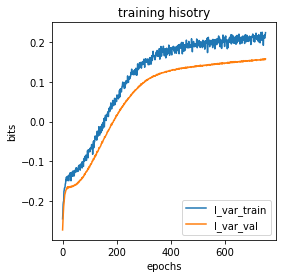

In [20]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

fig.savefig('pngs/DiscreteMonotonic_MP/history.png',dpi=200,bbox_inches='tight')

In [21]:
phi = gpmap.x_to_phi(x_test)

In [22]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

In [23]:
#gpmap.weights[1].numpy()

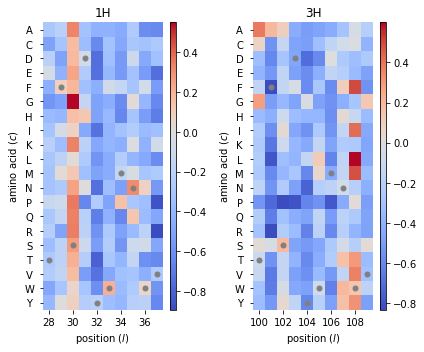

In [24]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/GP_map.png',dpi=200,bbox_inches='tight')

In [25]:
#np.save('titeseq_gpmap_discrete_agnostic',logo.df.values.ravel())

In [26]:
# sortseq_gpmap = np.load('sortseq_gpmap_discrete_agnostic.npy')
# titeseq_gpmap = -np.load('titeseq_gpmap_discrete_agnostic.npy')

In [27]:
# plt.figure(figsize=(5,5))
# # Compute R^2 between yhat_test and y_test
# Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# # Style plot
# xlim = [-1.5, 1.5]

# plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
# plt.xlabel('Sortseq G-P map parameters')
# plt.ylabel('Titeseq G-P map parameters')
# plt.title(f'$R^2$={Rsq:.3}');
# plt.plot(xlim, xlim, '--', color='k', label='diagonal')
# plt.xlim(xlim)
# plt.ylim(xlim)
# plt.show()

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_31032/2993366307.py:46: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


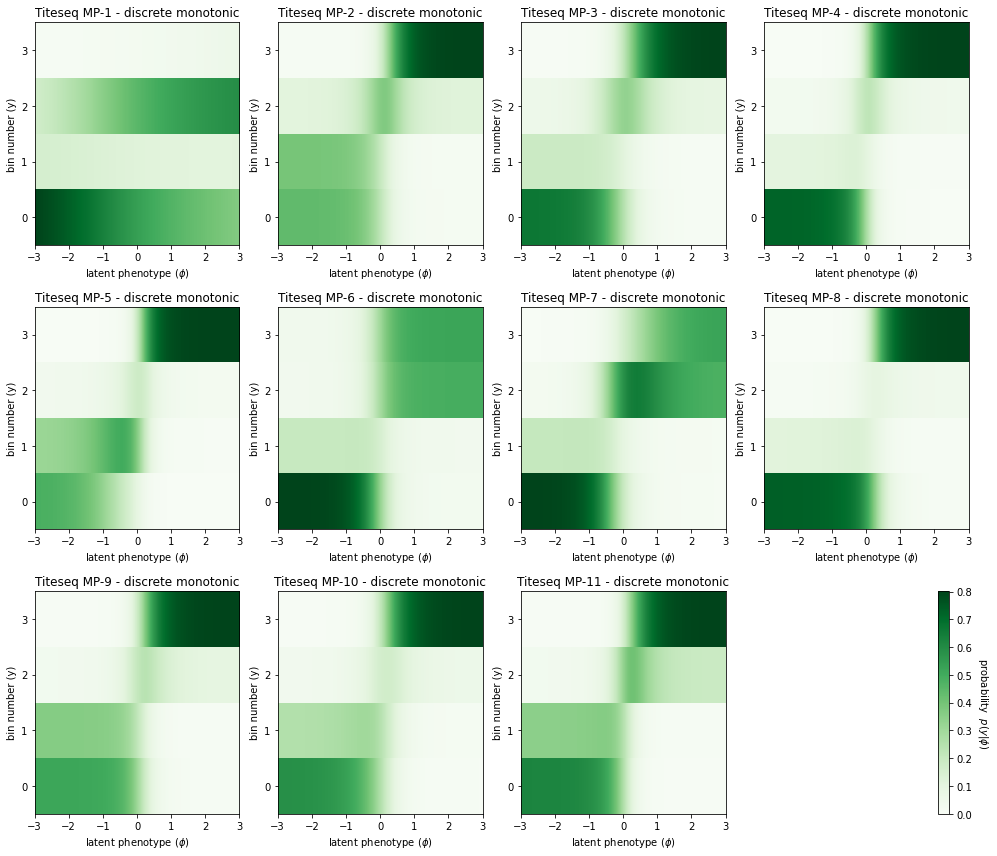

In [28]:
# Create grid in phi space
phi_lim = [-3, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0
for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/DiscreteMonotonic_MP/MPs.png',dpi=200,bbox_inches='tight')


/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_31032/4163575850.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


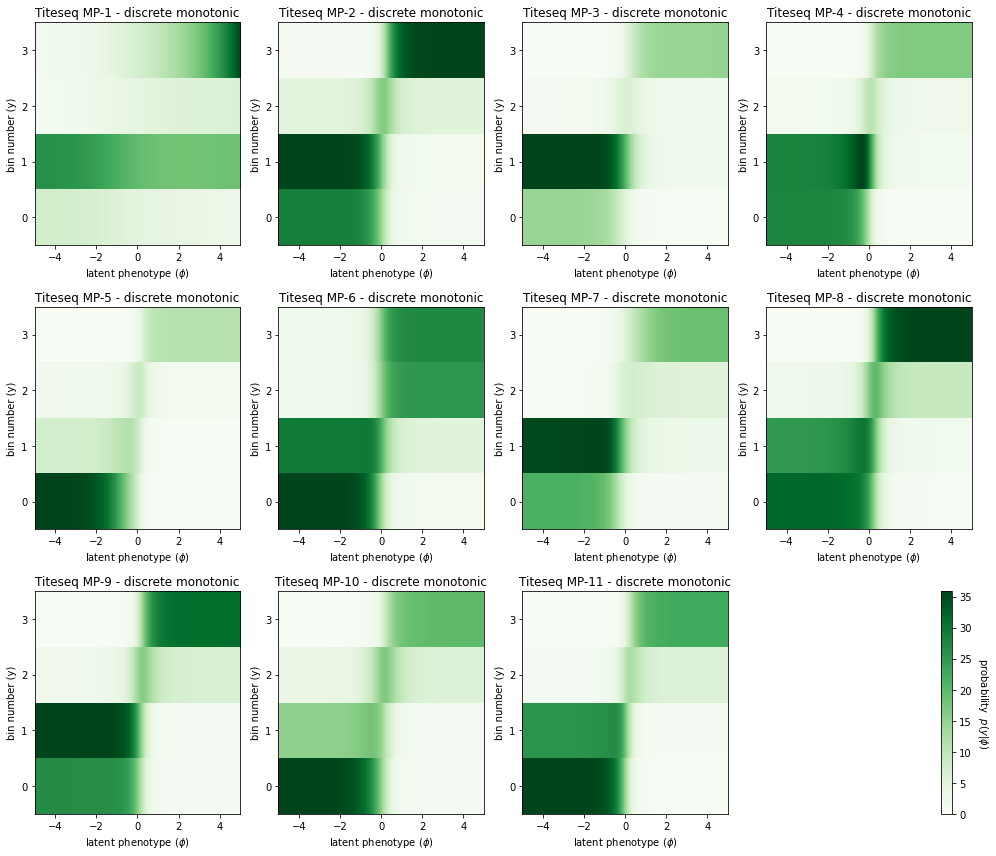

In [29]:
# Create grid in phi space
phi_lim = [-5, 5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0
for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        
        p_y_mp = N_y[4*mp_counter:4*mp_counter+4]/np.sum(N_y)
        
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]
        im = ax.imshow(measurement_process/p_y_mp.values.reshape(4,1),
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/DiscreteMonotonic_MP/MPs_norm.png',dpi=200,bbox_inches='tight')


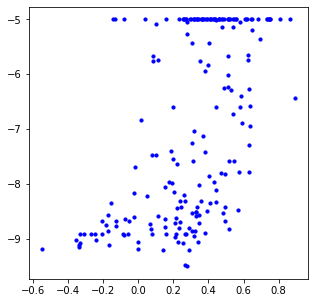

In [30]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
ax = axs
ax.scatter(-theta_df.loc[0:9].values,np.load('CDR1H.raw.heatmap.npy'),color='blue',s=10)


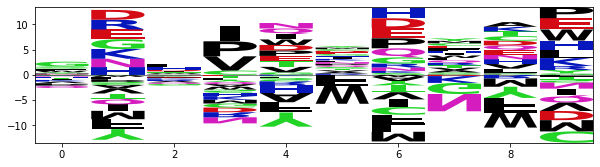

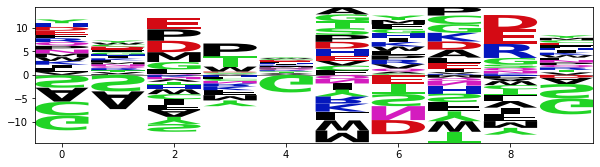

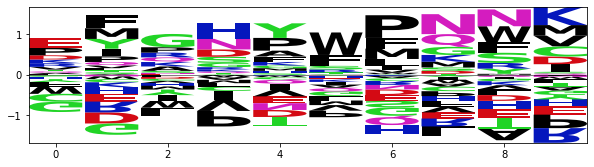

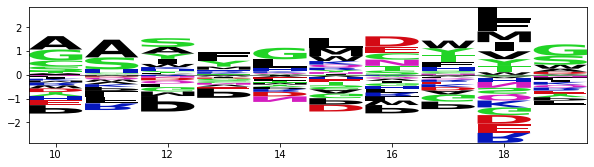

In [31]:
CDR1H_titeseq_df = pd.DataFrame(np.load('CDR1H.raw.heatmap.npy'),columns=model.alphabet)
CDR1H_titeseq_logo = logomaker.Logo(CDR1H_titeseq_df,center_values=True)

CDR3H_titeseq_df = pd.DataFrame(np.load('CDR3H.raw.heatmap.npy'),columns=model.alphabet)
CDR3H_titeseq_logo = logomaker.Logo(CDR3H_titeseq_df,center_values=True)

mavenn2_CDR1H_logo = logomaker.Logo(theta_df.loc[0:9],center_values=True)

mavenn2_CDR3H_logo = logomaker.Logo(theta_df.loc[10:20],center_values=True)

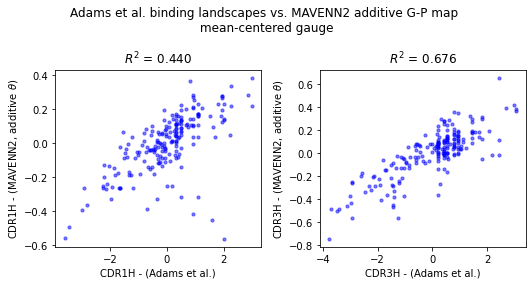

In [32]:
fig, axs = plt.subplots(1,2,figsize=(7.5,4))
ax = axs[0]

Rsq = np.corrcoef(CDR1H_titeseq_logo.df.values.ravel(),-mavenn2_CDR1H_logo.df.values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(CDR1H_titeseq_logo.df.values.ravel(),-mavenn2_CDR1H_logo.df.values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Adams et al.)')
ax.set_ylabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_logo.df.values.ravel(),-mavenn2_CDR3H_logo.df.values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(CDR3H_titeseq_logo.df.values.ravel(),
           -mavenn2_CDR3H_logo.df.values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Adams et al.)')
ax.set_ylabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n mean-centered gauge ')
fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/Adams_vs_mavenn_GP_map.png',dpi=200,bbox_inches='tight')


In [33]:
# # Manual Gauge fixing
#from mavenn.src.utils import _x_to_mat

def _x_to_mat1(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] ==
            np.array(alphabet)[np.newaxis, :]).astype(float)

def manual_WT_gauge(theta_lc,L,WT_seq,theta_0=0,model=model):

    C = model.C
    p_lc = _x_to_mat1(WT_seq, list(model.alphabet))

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]  
    
    return fixed_theta_lc
# np.save('theta_lc_AIE_gf',fixed_theta_lc)

In [34]:
CDR1H_titeseq_WT_gauge = manual_WT_gauge(CDR1H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][0:10],L=10)
CDR3H_titeseq_WT_gauge = manual_WT_gauge(CDR3H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][10:20],L=10)


In [35]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

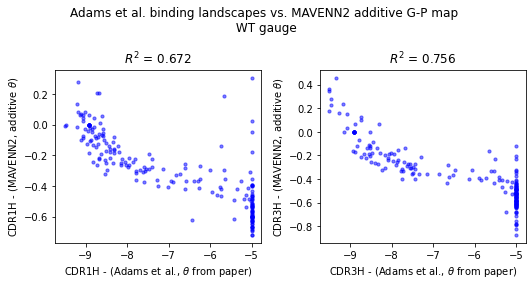

In [36]:
theta_lc_consensus_df.loc[0:9]
fig, axs = plt.subplots(1,2,figsize=(7.5,4))
ax = axs[0]

Rsq = np.corrcoef(-CDR1H_titeseq_df.values.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(CDR1H_titeseq_df.values.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Adams et al., $\\theta$ from paper)')
ax.set_ylabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_df.values.ravel(),-theta_lc_consensus_df.loc[10:20].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(CDR3H_titeseq_df.values.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Adams et al., $\\theta$ from paper)')
ax.set_ylabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n WT gauge ')
fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/Adams_vs_mavenn_GP_map_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


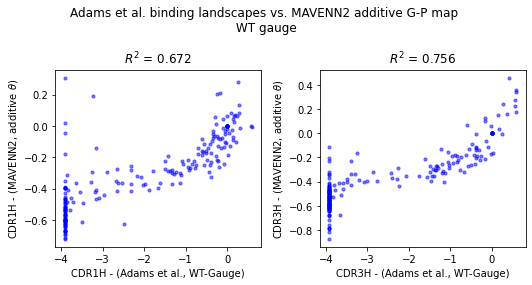

In [37]:
theta_lc_consensus_df.loc[0:9]
fig, axs = plt.subplots(1,2,figsize=(7.5,4))
ax = axs[0]

Rsq = np.corrcoef(CDR1H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(-CDR1H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Adams et al., WT-Gauge)')
ax.set_ylabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(-CDR3H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Adams et al., WT-Gauge)')
ax.set_ylabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n WT gauge ')
fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/Adams_vs_mavenn_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


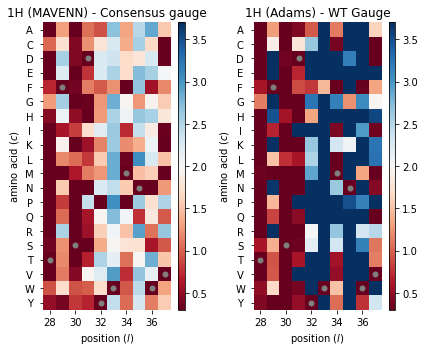

In [38]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=-theta_lc_consensus_df.loc[0:9].values/np.std(theta_lc_consensus_df.loc[0:9].values),
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][0:10],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                clim=[0.3,3.7],
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H (MAVENN) - Consensus gauge')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=CDR1H_titeseq_WT_gauge,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][0:10],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                clim=[0.3,3.7],
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H (Adams) - WT Gauge')

fig.tight_layout()
#fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n mean-centered gauge ')
fig.savefig('pngs/DiscreteMonotonic_MP/GP_map_consensus_gauge.png',dpi=200,bbox_inches='tight')

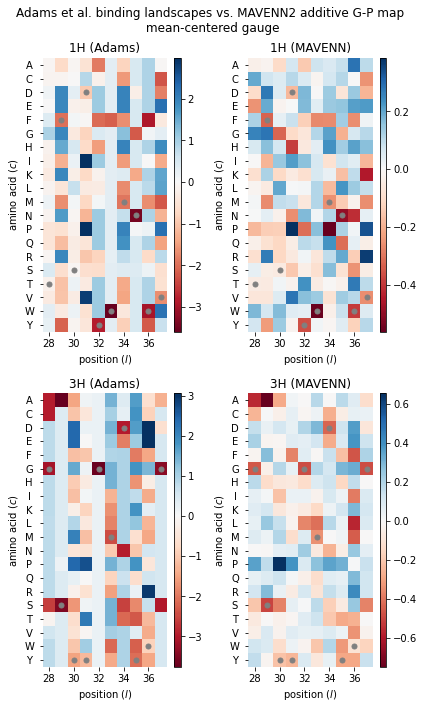

In [39]:
fig, axs = plt.subplots(2,2, figsize=(6,10))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0,0],
                                values=CDR1H_titeseq_logo.df.values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][0:10],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H (Adams)')


heatmap_ax, cb = mavenn.heatmap(ax=axs[0,1],
                                values=-mavenn2_CDR1H_logo.df.values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][0:10],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H (MAVENN)')


# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[1,0],
                                values=CDR3H_titeseq_logo.df.values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][10:20],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H (Adams)')


heatmap_ax, cb = mavenn.heatmap(ax=axs[1,1],
                                values=-mavenn2_CDR3H_logo.df.values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'][10:20],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='RdBu',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H (MAVENN)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n mean-centered gauge ')
fig.tight_layout()
fig.savefig('pngs/DiscreteMonotonic_MP/landscape_comparisons.png',dpi=200,bbox_inches='tight')

In [40]:
# np.save('models/theta_0_DM.npy',model.model.get_weights()[0])
# np.save('models/theta_lc_DM.npy',model.model.get_weights()[1])